In [1]:
# ------------------------------------------------------------------
# Helper function for inclination correction
# ------------------------------------------------------------------

def read_galaxy_inclination(galaxy_name, inclination_file="MAUVE_Inclination.dat"):
    """
    Read galaxy inclination from MAUVE_Inclination.dat file.
    
    Parameters:
    -----------
    galaxy_name : str
        Name of the galaxy (e.g., 'IC3392')
    inclination_file : str
        Path to the inclination data file
        
    Returns:
    --------
    float
        Inclination angle in degrees, or None if galaxy not found
    """
    try:
        with open(inclination_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 2 and parts[0].upper() == galaxy_name.upper():
                    return float(parts[1])
        print(f"Warning: Galaxy {galaxy_name} not found in {inclination_file}")
        return None
    except FileNotFoundError:
        print(f"Warning: Inclination file {inclination_file} not found")
        return None
    except Exception as e:
        print(f"Warning: Error reading inclination file: {e}")
        return None

Galaxy IC3392: inclination = 68.0°, b/a = 0.418
Galaxy NGC4064: inclination = 70.0°, b/a = 0.390
Galaxy NGC4192: inclination = 83.0°, b/a = 0.233
Galaxy NGC4293: inclination = 67.0°, b/a = 0.432
Galaxy NGC4298: inclination = 52.0°, b/a = 0.636
Galaxy NGC4330: inclination = 90.0°, b/a = 0.200
Galaxy NGC4383: inclination = 56.0°, b/a = 0.583
Galaxy NGC4396: inclination = 83.0°, b/a = 0.233
Galaxy NGC4419: inclination = 74.0°, b/a = 0.336
Galaxy NGC4457: inclination = 37.0°, b/a = 0.808
Galaxy NGC4501: inclination = 65.0°, b/a = 0.460
Galaxy NGC4522: inclination = 82.0°, b/a = 0.242
Galaxy NGC4694: inclination = 62.0°, b/a = 0.502
Galaxy NGC4698: inclination = 66.0°, b/a = 0.446


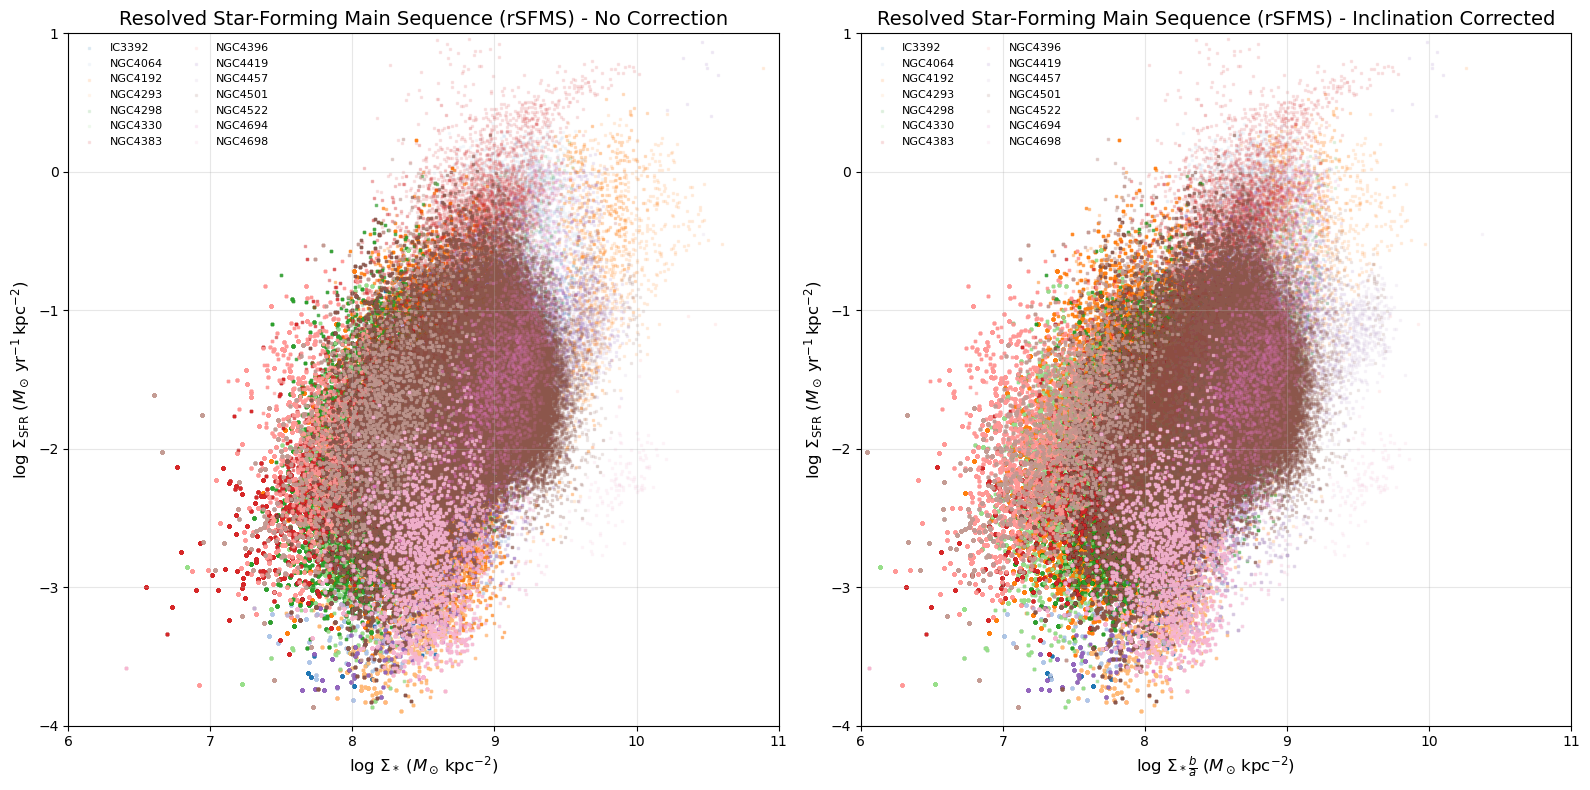

Subplot 1: Plotted uncorrected spatially-resolved SFMS data for 14 galaxies
Subplot 2: Plotted inclination-corrected spatially-resolved data for 14 galaxies


In [2]:
# ------------------------------------------------------------------
# Combined Plot: Resolved SFMS (No correction) + Spatially-resolved Star Formation (Inclination-Corrected)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Spatially-resolved Σ* vs ΣSFR (No Inclination Correction)
# ------------------------------------------------------------------

def sfms_leroy2019(logM, scatter=0.36, valid=(9.5, 11.0)):
    """Leroy+2019 eq.19 converted to log SFR: logSFR = 0.68*logM - 6.97."""
    y = 0.68 * np.asarray(logM) - 6.97
    # mask outside their stated mass range
    y = np.where((logM < valid[0]) | (logM > valid[1]), np.nan, y)
    return y

def sfms_boselli2023(logM, slope=0.92, intercept=-1.57, x_pivot=8.451, scatter=0.42):
    """
    Boselli+2023 (HRS, HI-def ≤ 0.4): fit with pivot x_pivot.
    y = slope * (logM - x_pivot) + intercept
    """
    logM = np.asarray(logM)
    y = slope * (logM - x_pivot) + intercept
    return y

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Colour cycle for spatially-resolved plot (subplot 1)
colors_spatial_left = itertools.cycle(plt.cm.tab20.colors)

# Collect all data points for global fit (subplot 1)
all_x_left = []
all_y_left = []

for gal, colour in zip(galaxies, colors_spatial_left):
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions (NO inclination correction for subplot 1)
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            logSigmaSFR = hdul['LOGSFR_SURFACE_DENSITY_SF'].data  # Σ_SFR

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(logSigmaSFR)

        # NO inclination correction applied for subplot 1
        logSigmaM_uncorr = logSigmaM[good]

        # Scatter plot without inclination correction
        ax1.scatter(
            logSigmaM_uncorr,
            logSigmaSFR[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=colour,
            label=gal
        )
        
        # Collect points for global fit
        all_x_left.extend(logSigmaM_uncorr)
        all_y_left.extend(logSigmaSFR[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 1
ax1.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax1.set_ylabel(r'$\log\,\Sigma_{\mathrm{SFR}}\; (M_\odot\,\mathrm{yr}^{-1}\,\mathrm{kpc}^{-2})$', fontsize=12)
ax1.set_title(r'Resolved Star-Forming Main Sequence (rSFMS) - No Correction', fontsize=14)
ax1.set_xlim(6, 11)
ax1.set_ylim(-4, 1)
ax1.grid(True, alpha=0.3)
ax1.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs ΣSFR (Inclination-Corrected)
# ------------------------------------------------------------------

# Colour cycle for spatially-resolved plot
colors_spatial = itertools.cycle(plt.cm.tab20.colors)

# Collect all data points for global fit
all_x = []
all_y = []

for gal, colour in zip(galaxies, colors_spatial):
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Get galaxy inclination
    galaxy_inclination = read_galaxy_inclination(gal)
    if galaxy_inclination is None:
        print(f"Warning: Skipping {gal} - no inclination data, using uncorrected values")
        inclination_correction = 0.0  # no correction in log space
    else:
        inclination_rad = np.deg2rad(galaxy_inclination)
        cos_inclination = np.cos(inclination_rad)
        # Calculate b/a factor: sqrt((1-q0^2)*cos^2(i) + q0^2) where q0=0.2
        ba_factor = np.abs(np.sqrt((1-0.2**2)*cos_inclination**2 + 0.2**2))
        inclination_correction = np.log10(ba_factor)
        print(f"Galaxy {gal}: inclination = {galaxy_inclination}°, b/a = {ba_factor:.3f}")

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            logSigmaSFR = hdul['LOGSFR_SURFACE_DENSITY_SF'].data  # Σ_SFR

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(logSigmaSFR)

        # Apply inclination correction to stellar mass surface density
        logSigmaM_corr = logSigmaM[good] + inclination_correction

        # Scatter plot with inclination-corrected stellar mass surface density
        ax2.scatter(
            logSigmaM_corr,
            logSigmaSFR[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=colour,
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM_corr)
        all_y.extend(logSigmaSFR[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \frac{b}{a} \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'$\log\,\Sigma_{\mathrm{SFR}}\; (M_\odot\,\mathrm{yr}^{-1}\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_title(r'Resolved Star-Forming Main Sequence (rSFMS) - Inclination Corrected', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(-4, 1)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted uncorrected spatially-resolved SFMS data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")
print(f"Subplot 2: Plotted inclination-corrected spatially-resolved data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

Galaxy IC3392: inclination = 68.0°, b/a = 0.418
Galaxy NGC4064: inclination = 70.0°, b/a = 0.390
Galaxy NGC4192: inclination = 83.0°, b/a = 0.233
Galaxy NGC4293: inclination = 67.0°, b/a = 0.432
Galaxy NGC4298: inclination = 52.0°, b/a = 0.636
Galaxy NGC4330: inclination = 90.0°, b/a = 0.200
Galaxy NGC4383: inclination = 56.0°, b/a = 0.583
Galaxy NGC4396: inclination = 83.0°, b/a = 0.233
Galaxy NGC4419: inclination = 74.0°, b/a = 0.336
Galaxy NGC4457: inclination = 37.0°, b/a = 0.808
Galaxy NGC4501: inclination = 65.0°, b/a = 0.460
Galaxy NGC4522: inclination = 82.0°, b/a = 0.242
Galaxy NGC4694: inclination = 62.0°, b/a = 0.502
Galaxy NGC4698: inclination = 66.0°, b/a = 0.446


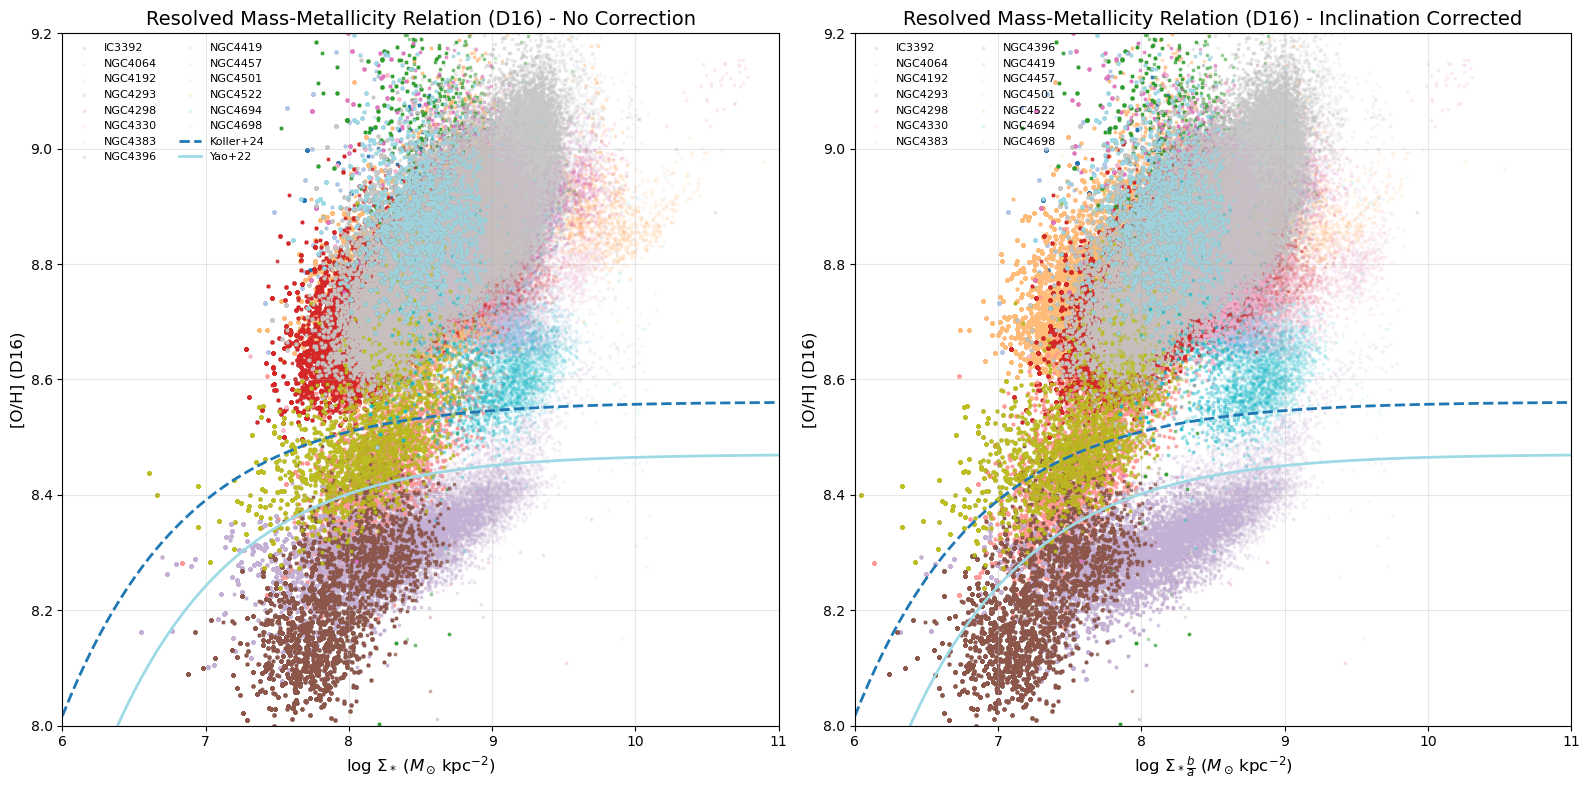

Subplot 1: Plotted uncorrected spatially-resolved D16 MZR data for 14 galaxies
Subplot 2: Plotted inclination-corrected spatially-resolved D16 MZR data for 14 galaxies


In [3]:
# ------------------------------------------------------------------
# Combined Plot: Resolved MZR (D16, No correction) + Resolved MZR (D16, Inclination-Corrected)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def plot_literature_mzr_fits(ax, show_legend=False):
    """Plot literature MZR fits on the given axis"""
    # Define x range for plotting literature fits
    x = np.linspace(6, 11, 100)
    
    # Yao+22
    # 12 + log(O/H) = a + b(log Σ* - c)e^(-(x-c))
    # Coefficients: a = 8.47, b = 0.0002, c = 12.36
    a1, b1, c1 = 8.47, 0.0002, 12.36
    y_yao22 = a1 + b1 * (x - c1) * np.exp(-(x - c1))

    # Koller+24
    # 12 + log(O/H) = a + b(log Σ* - c)exp(-(log Σ* - c))
    # Coefficients: a = 8.561, b = 0.0001, c = 12.7
    a2, b2, c2 = 8.561, 0.0001, 12.7
    y_koller24 = a2 + b2 * (x - c2) * np.exp(-(x - c2))

    # MZR literature data
    plot_data = [
        (y_koller24, 'Koller+24', '--'),
        (y_yao22, 'Yao+22', '-'),
    ]
    
    # Plot all literature fits
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    for i, (y, label, linestyle) in enumerate(plot_data):
        if show_legend:
            ax.plot(x, y, label=label, linewidth=2, linestyle=linestyle, color=colors[i])
        else:
            ax.plot(x, y, linewidth=2, linestyle=linestyle, color=colors[i])

def plot_previous_MZR(ax=None,
                      mass_range=(8.5, 11.5),
                      zahid_params=dict(Z0=8.710, logM0=8.76, gamma=0.66),
                      curti_params=dict(Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2),
                      include=('T04','Z14','C20'),
                      sanchez_calibs=("O3N2-M13", "PP04", "N2-M13", "T04", "D16"),
                      # NEW: off by default to preserve behavior
                      sanchez2017_calibs=(),
                      show_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.2, 4.8))

    logM = np.linspace(mass_range[0], mass_range[1], 800)

    # === Literature curves ===
    if 'T04' in include:
        ax.plot(logM, mzr_tremonti2004(logM), lw=2,
                label='Tremonti+2004 (SDSS, R23–T04)')
    if 'Z14' in include:
        z = mzr_zahid2014(logM, **zahid_params)
        ax.plot(logM, z, lw=2, ls='--',
                label='Zahid+2014 (SDSS, N2–PP04)')
    if 'C20' in include:
        c = mzr_curti2020(logM, **curti_params)
        ax.plot(logM, c, lw=2, ls=':',
                label='Curti+2020 (SDSS, Combined–C20)')

    # Sánchez+2019 (SAMI)
    for calib in sanchez_calibs:
        if calib not in S19_PARAMS:
            continue
        pars = S19_PARAMS[calib]
        y = mzr_sanchez2019(logM, **pars)
        ls = S19_STYLES.get(calib, "-.")
        ax.plot(logM, y, lw=2, ls=ls, alpha=0.9,
                label=f"Sánchez+2019 (SAMI, {calib})")

    # --- NEW: Sánchez+2017 (CALIFA) optional overlay ---
    for calib in sanchez2017_calibs:
        if calib not in S17_PARAMS:
            continue
        pars = S17_PARAMS[calib]
        y = mzr_sanchez2017(logM, **pars)
        ax.plot(logM, y, lw=2, ls='--', alpha=0.9,
                label=f"Sánchez+2017 (CALIFA, {calib})")

    ax.set_xlim(mass_range)
    ax.set_xlabel(r'$\log_{10}(M_\star/M_\odot)$')
    ax.set_ylabel(r'$12+\log_{10}(\mathrm{O/H})$')
    ax.set_xlim(9, 11.5)
    ax.set_ylim(8.0, 9.2)
    ax.grid(True, alpha=0.3)
    if show_legend:
        ax.legend(frameon=False, ncol=2, fontsize=8)
    plt.tight_layout()
    return ax

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Spatially-resolved Σ* vs [O/H] D16 (No Inclination Correction)
# ------------------------------------------------------------------

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Collect all data points for global fit (subplot 1)
all_x_left = []
all_y_left = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions (NO inclination correction for subplot 1)
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_d16 = hdul['O_H_D16_SF'].data  # [O/H] D16

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_d16)

        # NO inclination correction applied for subplot 1
        logSigmaM_uncorr = logSigmaM[good]

        # Scatter plot using consistent galaxy colors (no inclination correction)
        ax1.scatter(
            logSigmaM_uncorr,
            oh_d16[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x_left.extend(logSigmaM_uncorr)
        all_y_left.extend(oh_d16[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 1
plot_literature_mzr_fits(ax1, show_legend=True)

# Final cosmetics for subplot 1
ax1.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax1.set_ylabel(r'[O/H] (D16)', fontsize=12)
ax1.set_title(r'Resolved Mass-Metallicity Relation (D16) - No Correction', fontsize=14)
ax1.set_xlim(6, 11)
ax1.set_ylim(8.0, 9.2)
ax1.grid(True, alpha=0.3)
ax1.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] D16 (Inclination-Corrected)
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Get galaxy inclination
    galaxy_inclination = read_galaxy_inclination(gal)
    if galaxy_inclination is None:
        print(f"Warning: Skipping {gal} - no inclination data, using uncorrected values")
        inclination_correction = 0.0  # no correction in log space
    else:
        inclination_rad = np.deg2rad(galaxy_inclination)
        cos_inclination = np.cos(inclination_rad)
        # Calculate b/a factor: sqrt((1-q0^2)*cos^2(i) + q0^2) where q0=0.2
        ba_factor = np.abs(np.sqrt((1-0.2**2)*cos_inclination**2 + 0.2**2))
        inclination_correction = np.log10(ba_factor)
        print(f"Galaxy {gal}: inclination = {galaxy_inclination}°, b/a = {ba_factor:.3f}")

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_d16 = hdul['O_H_D16_SF'].data  # [O/H] D16

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_d16)

        # Apply inclination correction to stellar mass surface density
        logSigmaM_corr = logSigmaM[good] + inclination_correction

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM_corr,
            oh_d16[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM_corr)
        all_y.extend(oh_d16[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 2
plot_literature_mzr_fits(ax2, show_legend=False)

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \frac{b}{a} \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (D16)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (D16) - Inclination Corrected', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted uncorrected spatially-resolved D16 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")
print(f"Subplot 2: Plotted inclination-corrected spatially-resolved D16 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

Galaxy IC3392: inclination = 68.0°, b/a = 0.418
Galaxy NGC4064: inclination = 70.0°, b/a = 0.390
Galaxy NGC4192: inclination = 83.0°, b/a = 0.233
Galaxy NGC4293: inclination = 67.0°, b/a = 0.432
Galaxy NGC4298: inclination = 52.0°, b/a = 0.636
Galaxy NGC4330: inclination = 90.0°, b/a = 0.200
Galaxy NGC4383: inclination = 56.0°, b/a = 0.583
Galaxy NGC4396: inclination = 83.0°, b/a = 0.233
Galaxy NGC4419: inclination = 74.0°, b/a = 0.336
Galaxy NGC4457: inclination = 37.0°, b/a = 0.808
Galaxy NGC4501: inclination = 65.0°, b/a = 0.460
Galaxy NGC4522: inclination = 82.0°, b/a = 0.242
Galaxy NGC4694: inclination = 62.0°, b/a = 0.502
Galaxy NGC4698: inclination = 66.0°, b/a = 0.446


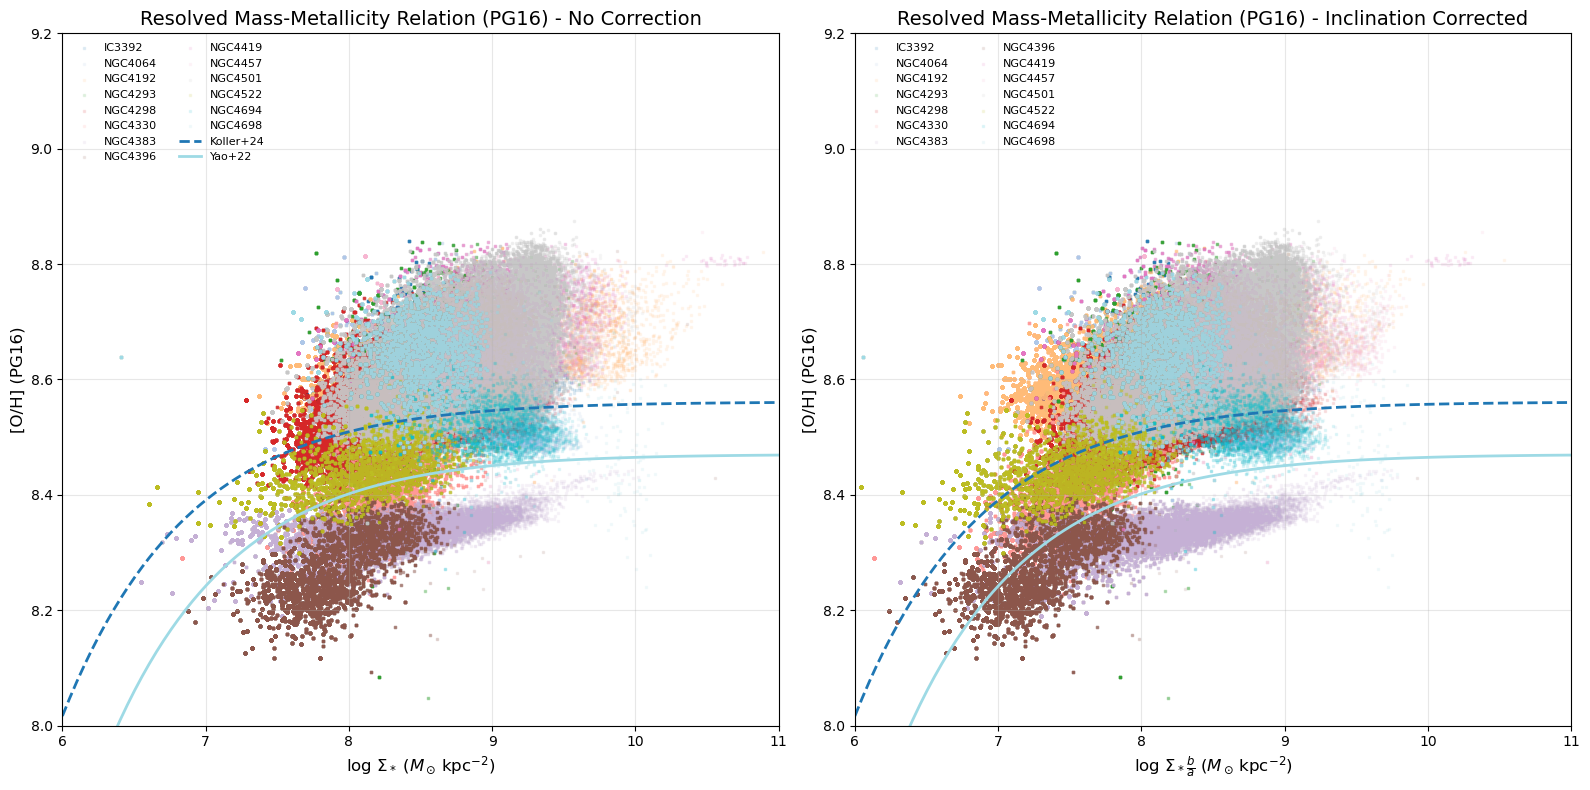

Subplot 1: Plotted uncorrected spatially-resolved PG16 MZR data for 14 galaxies
Subplot 2: Plotted inclination-corrected spatially-resolved PG16 MZR data for 14 galaxies


In [4]:
# ------------------------------------------------------------------
# Combined Plot: Resolved MZR (PG16, No correction) + Resolved MZR (PG16, Inclination-Corrected)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def plot_literature_mzr_fits(ax, show_legend=False):
    """Plot literature MZR fits on the given axis"""
    # Define x range for plotting literature fits
    x = np.linspace(6, 11, 100)
    
    # Yao+22
    # 12 + log(O/H) = a + b(log Σ* - c)e^(-(x-c))
    # Coefficients: a = 8.47, b = 0.0002, c = 12.36
    a1, b1, c1 = 8.47, 0.0002, 12.36
    y_yao22 = a1 + b1 * (x - c1) * np.exp(-(x - c1))

    # Koller+24
    # 12 + log(O/H) = a + b(log Σ* - c)exp(-(log Σ* - c))
    # Coefficients: a = 8.561, b = 0.0001, c = 12.7
    a2, b2, c2 = 8.561, 0.0001, 12.7
    y_koller24 = a2 + b2 * (x - c2) * np.exp(-(x - c2))

    # MZR literature data
    plot_data = [
        (y_koller24, 'Koller+24', '--'),
        (y_yao22, 'Yao+22', '-'),
    ]
    
    # Plot all literature fits
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    for i, (y, label, linestyle) in enumerate(plot_data):
        if show_legend:
            ax.plot(x, y, label=label, linewidth=2, linestyle=linestyle, color=colors[i])
        else:
            ax.plot(x, y, linewidth=2, linestyle=linestyle, color=colors[i])

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Spatially-resolved Σ* vs [O/H] PG16 (No Inclination Correction)
# ------------------------------------------------------------------

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Collect all data points for global fit (subplot 1)
all_x_left = []
all_y_left = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions (NO inclination correction for subplot 1)
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_pg16 = hdul['O_H_PG16_SF'].data  # [O/H] PG16

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_pg16)

        # NO inclination correction applied for subplot 1
        logSigmaM_uncorr = logSigmaM[good]

        # Scatter plot using consistent galaxy colors (no inclination correction)
        ax1.scatter(
            logSigmaM_uncorr,
            oh_pg16[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x_left.extend(logSigmaM_uncorr)
        all_y_left.extend(oh_pg16[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 1
plot_literature_mzr_fits(ax1, show_legend=True)

# Final cosmetics for subplot 1
ax1.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax1.set_ylabel(r'[O/H] (PG16)', fontsize=12)
ax1.set_title(r'Resolved Mass-Metallicity Relation (PG16) - No Correction', fontsize=14)
ax1.set_xlim(6, 11)
ax1.set_ylim(8.0, 9.2)
ax1.grid(True, alpha=0.3)
ax1.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] PG16 (Inclination-Corrected)
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Get galaxy inclination
    galaxy_inclination = read_galaxy_inclination(gal)
    if galaxy_inclination is None:
        print(f"Warning: Skipping {gal} - no inclination data, using uncorrected values")
        inclination_correction = 0.0  # no correction in log space
    else:
        inclination_rad = np.deg2rad(galaxy_inclination)
        cos_inclination = np.cos(inclination_rad)
        # Calculate b/a factor: sqrt((1-q0^2)*cos^2(i) + q0^2) where q0=0.2
        ba_factor = np.abs(np.sqrt((1-0.2**2)*cos_inclination**2 + 0.2**2))
        inclination_correction = np.log10(ba_factor)
        print(f"Galaxy {gal}: inclination = {galaxy_inclination}°, b/a = {ba_factor:.3f}")

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_pg16 = hdul['O_H_PG16_SF'].data  # [O/H] PG16

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_pg16)

        # Apply inclination correction to stellar mass surface density
        logSigmaM_corr = logSigmaM[good] + inclination_correction

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM_corr,
            oh_pg16[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM_corr)
        all_y.extend(oh_pg16[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 2
plot_literature_mzr_fits(ax2, show_legend=False)

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \frac{b}{a} \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (PG16)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (PG16) - Inclination Corrected', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted uncorrected spatially-resolved PG16 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")
print(f"Subplot 2: Plotted inclination-corrected spatially-resolved PG16 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

Galaxy IC3392: inclination = 68.0°, b/a = 0.418
Galaxy NGC4064: inclination = 70.0°, b/a = 0.390
Galaxy NGC4192: inclination = 83.0°, b/a = 0.233
Galaxy NGC4293: inclination = 67.0°, b/a = 0.432
Galaxy NGC4298: inclination = 52.0°, b/a = 0.636
Galaxy NGC4330: inclination = 90.0°, b/a = 0.200
Galaxy NGC4383: inclination = 56.0°, b/a = 0.583
Galaxy NGC4396: inclination = 83.0°, b/a = 0.233
Galaxy NGC4419: inclination = 74.0°, b/a = 0.336
Galaxy NGC4457: inclination = 37.0°, b/a = 0.808
Galaxy NGC4501: inclination = 65.0°, b/a = 0.460
Galaxy NGC4522: inclination = 82.0°, b/a = 0.242
Galaxy NGC4694: inclination = 62.0°, b/a = 0.502
Galaxy NGC4698: inclination = 66.0°, b/a = 0.446


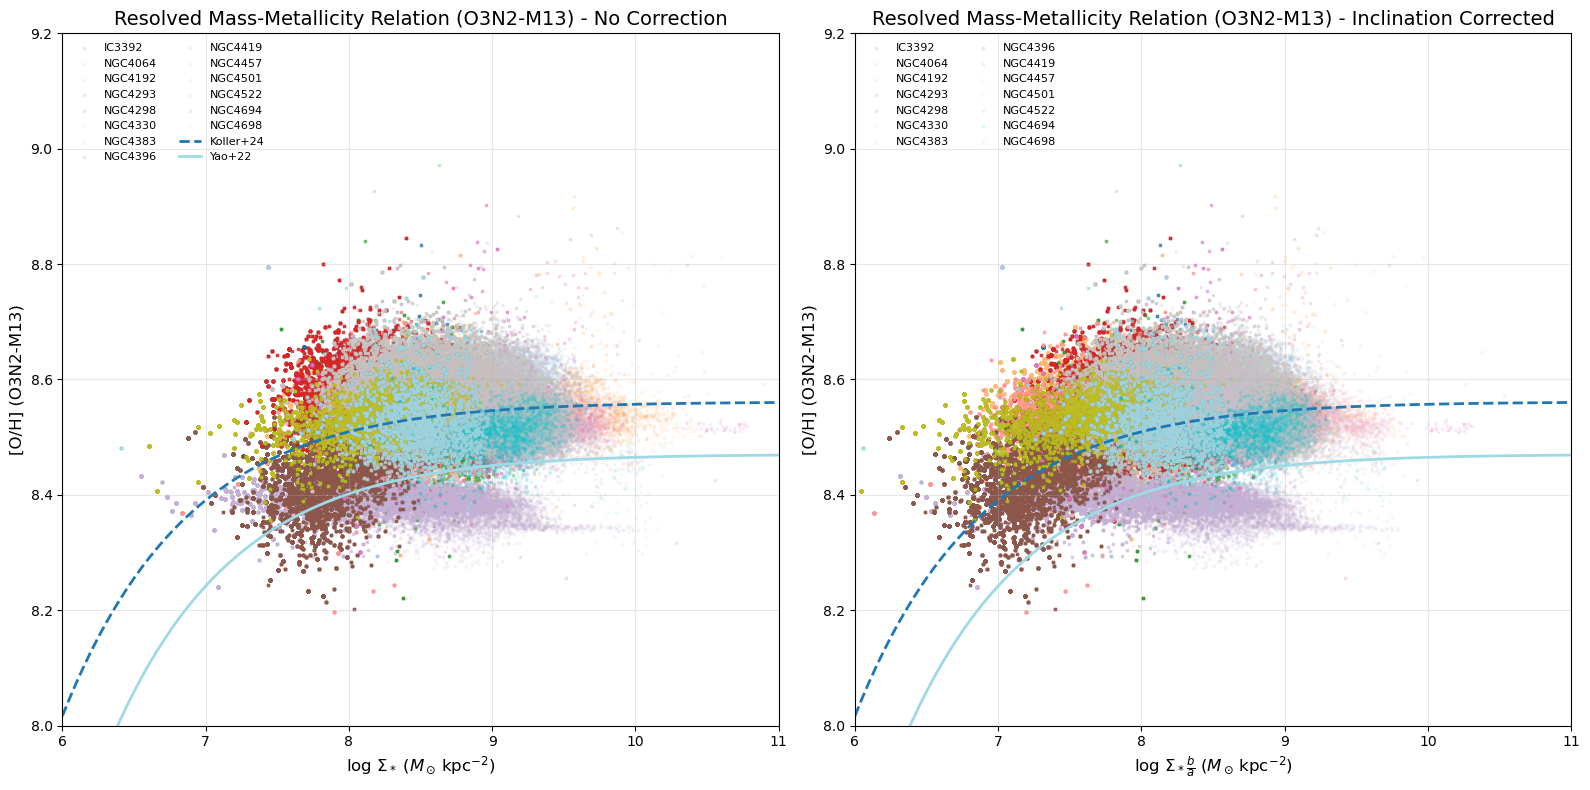

Subplot 1: Plotted uncorrected spatially-resolved O3N2-M13 MZR data for 14 galaxies
Subplot 2: Plotted inclination-corrected spatially-resolved O3N2-M13 MZR data for 14 galaxies


In [5]:
# ------------------------------------------------------------------
# Combined Plot: Resolved MZR (O3N2-M13, No correction) + Resolved MZR (O3N2-M13, Inclination-Corrected)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def plot_literature_mzr_fits(ax, show_legend=False):
    """Plot literature MZR fits on the given axis"""
    # Define x range for plotting literature fits
    x = np.linspace(6, 11, 100)
    
    # Yao+22
    # 12 + log(O/H) = a + b(log Σ* - c)e^(-(x-c))
    # Coefficients: a = 8.47, b = 0.0002, c = 12.36
    a1, b1, c1 = 8.47, 0.0002, 12.36
    y_yao22 = a1 + b1 * (x - c1) * np.exp(-(x - c1))

    # Koller+24
    # 12 + log(O/H) = a + b(log Σ* - c)exp(-(log Σ* - c))
    # Coefficients: a = 8.561, b = 0.0001, c = 12.7
    a2, b2, c2 = 8.561, 0.0001, 12.7
    y_koller24 = a2 + b2 * (x - c2) * np.exp(-(x - c2))

    # MZR literature data
    plot_data = [
        (y_koller24, 'Koller+24', '--'),
        (y_yao22, 'Yao+22', '-'),
    ]
    
    # Plot all literature fits
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    for i, (y, label, linestyle) in enumerate(plot_data):
        if show_legend:
            ax.plot(x, y, label=label, linewidth=2, linestyle=linestyle, color=colors[i])
        else:
            ax.plot(x, y, linewidth=2, linestyle=linestyle, color=colors[i])

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Spatially-resolved Σ* vs [O/H] O3N2-M13 (No Inclination Correction)
# ------------------------------------------------------------------

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Collect all data points for global fit (subplot 1)
all_x_left = []
all_y_left = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions (NO inclination correction for subplot 1)
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_o3n2_m13 = hdul['O_H_O3N2_M13_SF'].data  # [O/H] O3N2-M13

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_o3n2_m13)

        # NO inclination correction applied for subplot 1
        logSigmaM_uncorr = logSigmaM[good]

        # Scatter plot using consistent galaxy colors (no inclination correction)
        ax1.scatter(
            logSigmaM_uncorr,
            oh_o3n2_m13[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x_left.extend(logSigmaM_uncorr)
        all_y_left.extend(oh_o3n2_m13[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 1
plot_literature_mzr_fits(ax1, show_legend=True)

# Final cosmetics for subplot 1
ax1.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax1.set_ylabel(r'[O/H] (O3N2-M13)', fontsize=12)
ax1.set_title(r'Resolved Mass-Metallicity Relation (O3N2-M13) - No Correction', fontsize=14)
ax1.set_xlim(6, 11)
ax1.set_ylim(8.0, 9.2)
ax1.grid(True, alpha=0.3)
ax1.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] O3N2-M13 (Inclination-Corrected)
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Get galaxy inclination
    galaxy_inclination = read_galaxy_inclination(gal)
    if galaxy_inclination is None:
        print(f"Warning: Skipping {gal} - no inclination data, using uncorrected values")
        inclination_correction = 0.0  # no correction in log space
    else:
        inclination_rad = np.deg2rad(galaxy_inclination)
        cos_inclination = np.cos(inclination_rad)
        # Calculate b/a factor: sqrt((1-q0^2)*cos^2(i) + q0^2) where q0=0.2
        ba_factor = np.abs(np.sqrt((1-0.2**2)*cos_inclination**2 + 0.2**2))
        inclination_correction = np.log10(ba_factor)
        print(f"Galaxy {gal}: inclination = {galaxy_inclination}°, b/a = {ba_factor:.3f}")

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_o3n2_m13 = hdul['O_H_O3N2_M13_SF'].data  # [O/H] O3N2-M13

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_o3n2_m13)

        # Apply inclination correction to stellar mass surface density
        logSigmaM_corr = logSigmaM[good] + inclination_correction

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM_corr,
            oh_o3n2_m13[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM_corr)
        all_y.extend(oh_o3n2_m13[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 2
plot_literature_mzr_fits(ax2, show_legend=False)

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \frac{b}{a} \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (O3N2-M13)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (O3N2-M13) - Inclination Corrected', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted uncorrected spatially-resolved O3N2-M13 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")
print(f"Subplot 2: Plotted inclination-corrected spatially-resolved O3N2-M13 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

Galaxy IC3392: inclination = 68.0°, b/a = 0.418
Galaxy NGC4064: inclination = 70.0°, b/a = 0.390
Galaxy NGC4192: inclination = 83.0°, b/a = 0.233
Galaxy NGC4293: inclination = 67.0°, b/a = 0.432
Galaxy NGC4298: inclination = 52.0°, b/a = 0.636
Galaxy NGC4330: inclination = 90.0°, b/a = 0.200
Galaxy NGC4383: inclination = 56.0°, b/a = 0.583
Galaxy NGC4396: inclination = 83.0°, b/a = 0.233
Galaxy NGC4419: inclination = 74.0°, b/a = 0.336
Galaxy NGC4457: inclination = 37.0°, b/a = 0.808
Galaxy NGC4501: inclination = 65.0°, b/a = 0.460
Galaxy NGC4522: inclination = 82.0°, b/a = 0.242
Galaxy NGC4694: inclination = 62.0°, b/a = 0.502
Galaxy NGC4698: inclination = 66.0°, b/a = 0.446


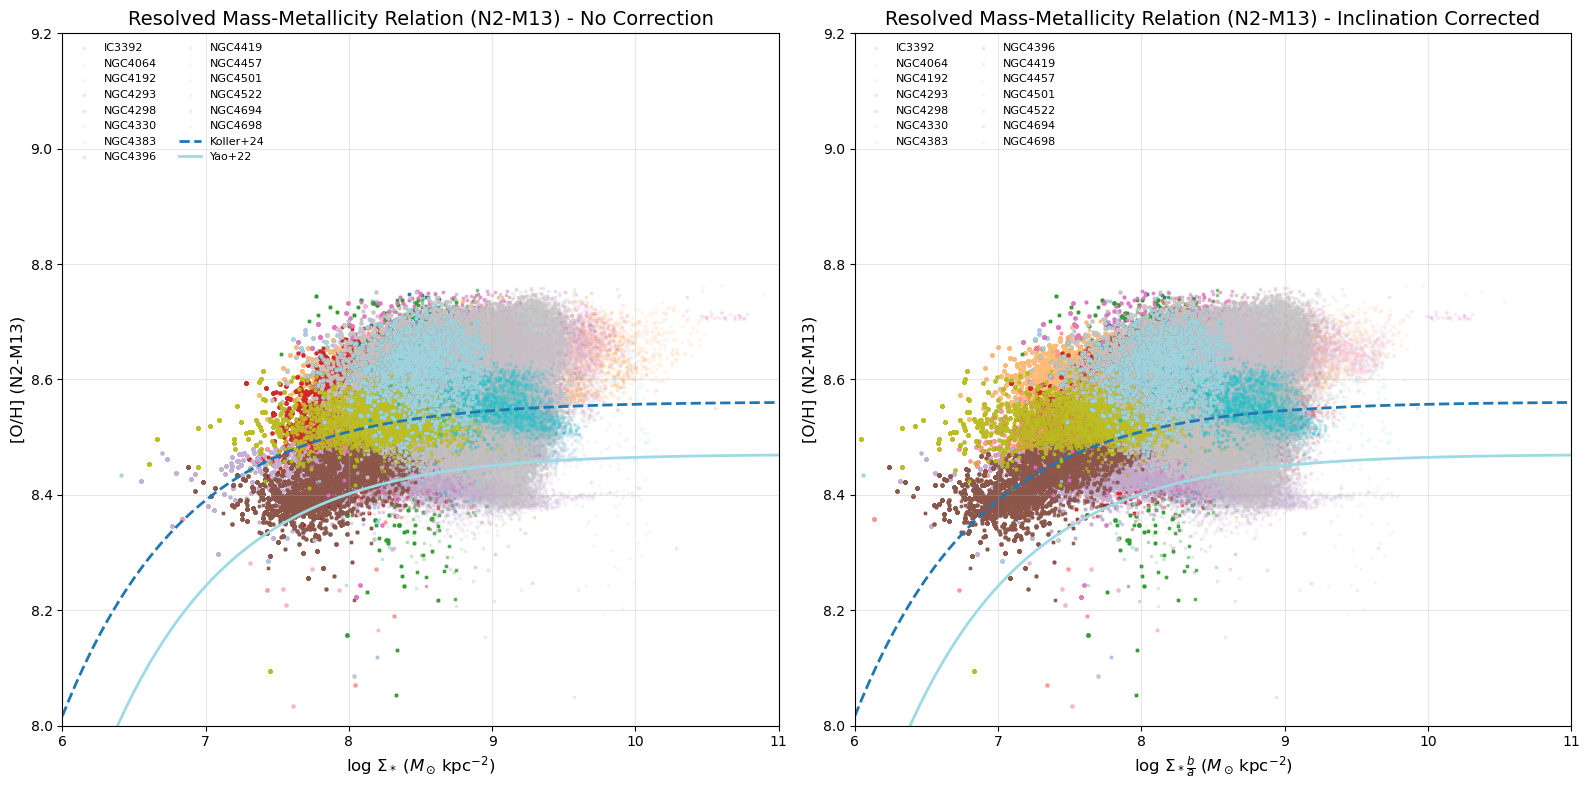

Subplot 1: Plotted uncorrected spatially-resolved N2-M13 MZR data for 14 galaxies
Subplot 2: Plotted inclination-corrected spatially-resolved N2-M13 MZR data for 14 galaxies


In [6]:
# ------------------------------------------------------------------
# Combined Plot: Resolved MZR (N2-M13, No correction) + Resolved MZR (N2-M13, Inclination-Corrected)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def plot_literature_mzr_fits(ax, show_legend=False):
    """Plot literature MZR fits on the given axis"""
    # Define x range for plotting literature fits
    x = np.linspace(6, 11, 100)
    
    # Yao+22
    # 12 + log(O/H) = a + b(log Σ* - c)e^(-(x-c))
    # Coefficients: a = 8.47, b = 0.0002, c = 12.36
    a1, b1, c1 = 8.47, 0.0002, 12.36
    y_yao22 = a1 + b1 * (x - c1) * np.exp(-(x - c1))

    # Koller+24
    # 12 + log(O/H) = a + b(log Σ* - c)exp(-(log Σ* - c))
    # Coefficients: a = 8.561, b = 0.0001, c = 12.7
    a2, b2, c2 = 8.561, 0.0001, 12.7
    y_koller24 = a2 + b2 * (x - c2) * np.exp(-(x - c2))

    # MZR literature data
    plot_data = [
        (y_koller24, 'Koller+24', '--'),
        (y_yao22, 'Yao+22', '-'),
    ]
    
    # Plot all literature fits
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    for i, (y, label, linestyle) in enumerate(plot_data):
        if show_legend:
            ax.plot(x, y, label=label, linewidth=2, linestyle=linestyle, color=colors[i])
        else:
            ax.plot(x, y, linewidth=2, linestyle=linestyle, color=colors[i])

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Spatially-resolved Σ* vs [O/H] N2-M13 (No Inclination Correction)
# ------------------------------------------------------------------

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Collect all data points for global fit (subplot 1)
all_x_left = []
all_y_left = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions (NO inclination correction for subplot 1)
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_n2_m13 = hdul['O_H_N2_M13_SF'].data  # [O/H] N2-M13

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_n2_m13)

        # NO inclination correction applied for subplot 1
        logSigmaM_uncorr = logSigmaM[good]

        # Scatter plot using consistent galaxy colors (no inclination correction)
        ax1.scatter(
            logSigmaM_uncorr,
            oh_n2_m13[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x_left.extend(logSigmaM_uncorr)
        all_y_left.extend(oh_n2_m13[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 1
plot_literature_mzr_fits(ax1, show_legend=True)

# Final cosmetics for subplot 1
ax1.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax1.set_ylabel(r'[O/H] (N2-M13)', fontsize=12)
ax1.set_title(r'Resolved Mass-Metallicity Relation (N2-M13) - No Correction', fontsize=14)
ax1.set_xlim(6, 11)
ax1.set_ylim(8.0, 9.2)
ax1.grid(True, alpha=0.3)
ax1.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] N2-M13 (Inclination-Corrected)
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Get galaxy inclination
    galaxy_inclination = read_galaxy_inclination(gal)
    if galaxy_inclination is None:
        print(f"Warning: Skipping {gal} - no inclination data, using uncorrected values")
        inclination_correction = 0.0  # no correction in log space
    else:
        inclination_rad = np.deg2rad(galaxy_inclination)
        cos_inclination = np.cos(inclination_rad)
        # Calculate b/a factor: sqrt((1-q0^2)*cos^2(i) + q0^2) where q0=0.2
        ba_factor = np.abs(np.sqrt((1-0.2**2)*cos_inclination**2 + 0.2**2))
        inclination_correction = np.log10(ba_factor)
        print(f"Galaxy {gal}: inclination = {galaxy_inclination}°, b/a = {ba_factor:.3f}")

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_n2_m13 = hdul['O_H_N2_M13_SF'].data  # [O/H] N2-M13

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_n2_m13)

        # Apply inclination correction to stellar mass surface density
        logSigmaM_corr = logSigmaM[good] + inclination_correction

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM_corr,
            oh_n2_m13[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM_corr)
        all_y.extend(oh_n2_m13[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 2
plot_literature_mzr_fits(ax2, show_legend=False)

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \frac{b}{a} \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (N2-M13)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (N2-M13) - Inclination Corrected', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted uncorrected spatially-resolved N2-M13 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")
print(f"Subplot 2: Plotted inclination-corrected spatially-resolved N2-M13 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

Galaxy IC3392: inclination = 68.0°, b/a = 0.418
Galaxy NGC4064: inclination = 70.0°, b/a = 0.390
Galaxy NGC4192: inclination = 83.0°, b/a = 0.233
Galaxy NGC4293: inclination = 67.0°, b/a = 0.432
Galaxy NGC4298: inclination = 52.0°, b/a = 0.636
Galaxy NGC4330: inclination = 90.0°, b/a = 0.200
Galaxy NGC4383: inclination = 56.0°, b/a = 0.583
Galaxy NGC4396: inclination = 83.0°, b/a = 0.233
Galaxy NGC4419: inclination = 74.0°, b/a = 0.336
Galaxy NGC4457: inclination = 37.0°, b/a = 0.808
Galaxy NGC4501: inclination = 65.0°, b/a = 0.460
Galaxy NGC4522: inclination = 82.0°, b/a = 0.242
Galaxy NGC4694: inclination = 62.0°, b/a = 0.502
Galaxy NGC4698: inclination = 66.0°, b/a = 0.446


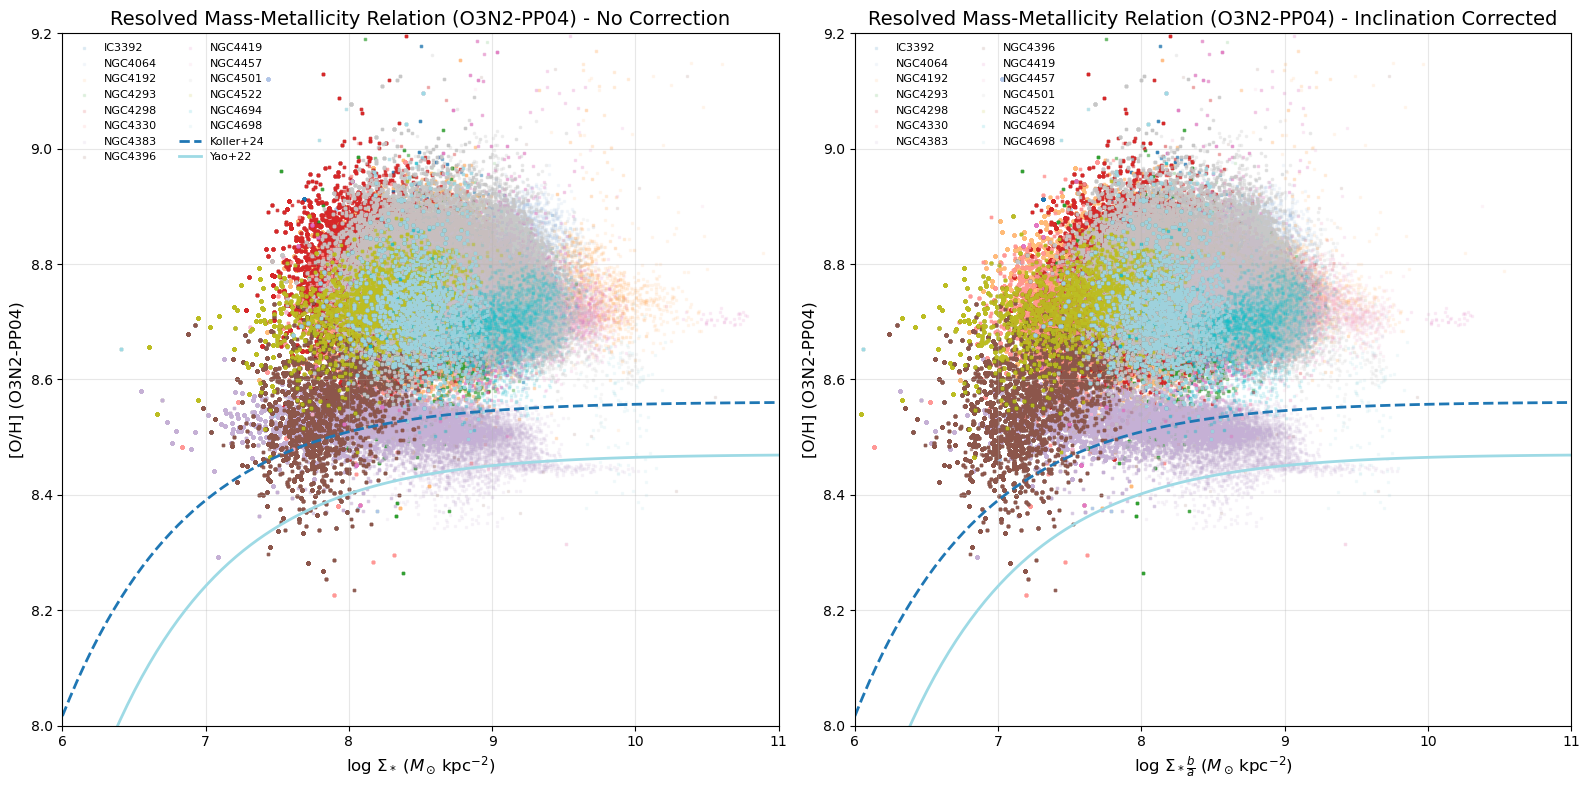

Subplot 1: Plotted uncorrected spatially-resolved O3N2-PP04 MZR data for 14 galaxies
Subplot 2: Plotted inclination-corrected spatially-resolved O3N2-PP04 MZR data for 14 galaxies


In [7]:
# ------------------------------------------------------------------
# Combined Plot: Resolved MZR (O3N2-PP04, No correction) + Resolved MZR (O3N2-PP04, Inclination-Corrected)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def plot_literature_mzr_fits(ax, show_legend=False):
    """Plot literature MZR fits on the given axis"""
    # Define x range for plotting literature fits
    x = np.linspace(6, 11, 100)
    
    # Yao+22
    # 12 + log(O/H) = a + b(log Σ* - c)e^(-(x-c))
    # Coefficients: a = 8.47, b = 0.0002, c = 12.36
    a1, b1, c1 = 8.47, 0.0002, 12.36
    y_yao22 = a1 + b1 * (x - c1) * np.exp(-(x - c1))

    # Koller+24
    # 12 + log(O/H) = a + b(log Σ* - c)exp(-(log Σ* - c))
    # Coefficients: a = 8.561, b = 0.0001, c = 12.7
    a2, b2, c2 = 8.561, 0.0001, 12.7
    y_koller24 = a2 + b2 * (x - c2) * np.exp(-(x - c2))

    # MZR literature data
    plot_data = [
        (y_koller24, 'Koller+24', '--'),
        (y_yao22, 'Yao+22', '-'),
    ]
    
    # Plot all literature fits
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    for i, (y, label, linestyle) in enumerate(plot_data):
        if show_legend:
            ax.plot(x, y, label=label, linewidth=2, linestyle=linestyle, color=colors[i])
        else:
            ax.plot(x, y, linewidth=2, linestyle=linestyle, color=colors[i])

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Spatially-resolved Σ* vs [O/H] O3N2-PP04 (No Inclination Correction)
# ------------------------------------------------------------------

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Collect all data points for global fit (subplot 1)
all_x_left = []
all_y_left = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions (NO inclination correction for subplot 1)
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_o3n2_pp04 = hdul['O_H_O3N2_PP04_SF'].data  # [O/H] O3N2-PP04

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_o3n2_pp04)

        # NO inclination correction applied for subplot 1
        logSigmaM_uncorr = logSigmaM[good]

        # Scatter plot using consistent galaxy colors (no inclination correction)
        ax1.scatter(
            logSigmaM_uncorr,
            oh_o3n2_pp04[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x_left.extend(logSigmaM_uncorr)
        all_y_left.extend(oh_o3n2_pp04[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 1
plot_literature_mzr_fits(ax1, show_legend=True)

# Final cosmetics for subplot 1
ax1.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax1.set_ylabel(r'[O/H] (O3N2-PP04)', fontsize=12)
ax1.set_title(r'Resolved Mass-Metallicity Relation (O3N2-PP04) - No Correction', fontsize=14)
ax1.set_xlim(6, 11)
ax1.set_ylim(8.0, 9.2)
ax1.grid(True, alpha=0.3)
ax1.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] O3N2-PP04 (Inclination-Corrected)
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Get galaxy inclination
    galaxy_inclination = read_galaxy_inclination(gal)
    if galaxy_inclination is None:
        print(f"Warning: Skipping {gal} - no inclination data, using uncorrected values")
        inclination_correction = 0.0  # no correction in log space
    else:
        inclination_rad = np.deg2rad(galaxy_inclination)
        cos_inclination = np.cos(inclination_rad)
        # Calculate b/a factor: sqrt((1-q0^2)*cos^2(i) + q0^2) where q0=0.2
        ba_factor = np.abs(np.sqrt((1-0.2**2)*cos_inclination**2 + 0.2**2))
        inclination_correction = np.log10(ba_factor)
        print(f"Galaxy {gal}: inclination = {galaxy_inclination}°, b/a = {ba_factor:.3f}")

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_o3n2_pp04 = hdul['O_H_O3N2_PP04_SF'].data  # [O/H] O3N2-PP04

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_o3n2_pp04)

        # Apply inclination correction to stellar mass surface density
        logSigmaM_corr = logSigmaM[good] + inclination_correction

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM_corr,
            oh_o3n2_pp04[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM_corr)
        all_y.extend(oh_o3n2_pp04[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 2
plot_literature_mzr_fits(ax2, show_legend=False)

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \frac{b}{a} \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (O3N2-PP04)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (O3N2-PP04) - Inclination Corrected', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted uncorrected spatially-resolved O3N2-PP04 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")
print(f"Subplot 2: Plotted inclination-corrected spatially-resolved O3N2-PP04 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

Galaxy IC3392: inclination = 68.0°, b/a = 0.418
Galaxy NGC4064: inclination = 70.0°, b/a = 0.390
Galaxy NGC4192: inclination = 83.0°, b/a = 0.233
Galaxy NGC4293: inclination = 67.0°, b/a = 0.432
Galaxy NGC4298: inclination = 52.0°, b/a = 0.636
Galaxy NGC4330: inclination = 90.0°, b/a = 0.200
Galaxy NGC4383: inclination = 56.0°, b/a = 0.583
Galaxy NGC4396: inclination = 83.0°, b/a = 0.233
Galaxy NGC4419: inclination = 74.0°, b/a = 0.336
Galaxy NGC4457: inclination = 37.0°, b/a = 0.808
Galaxy NGC4501: inclination = 65.0°, b/a = 0.460
Galaxy NGC4522: inclination = 82.0°, b/a = 0.242
Galaxy NGC4694: inclination = 62.0°, b/a = 0.502
Galaxy NGC4698: inclination = 66.0°, b/a = 0.446


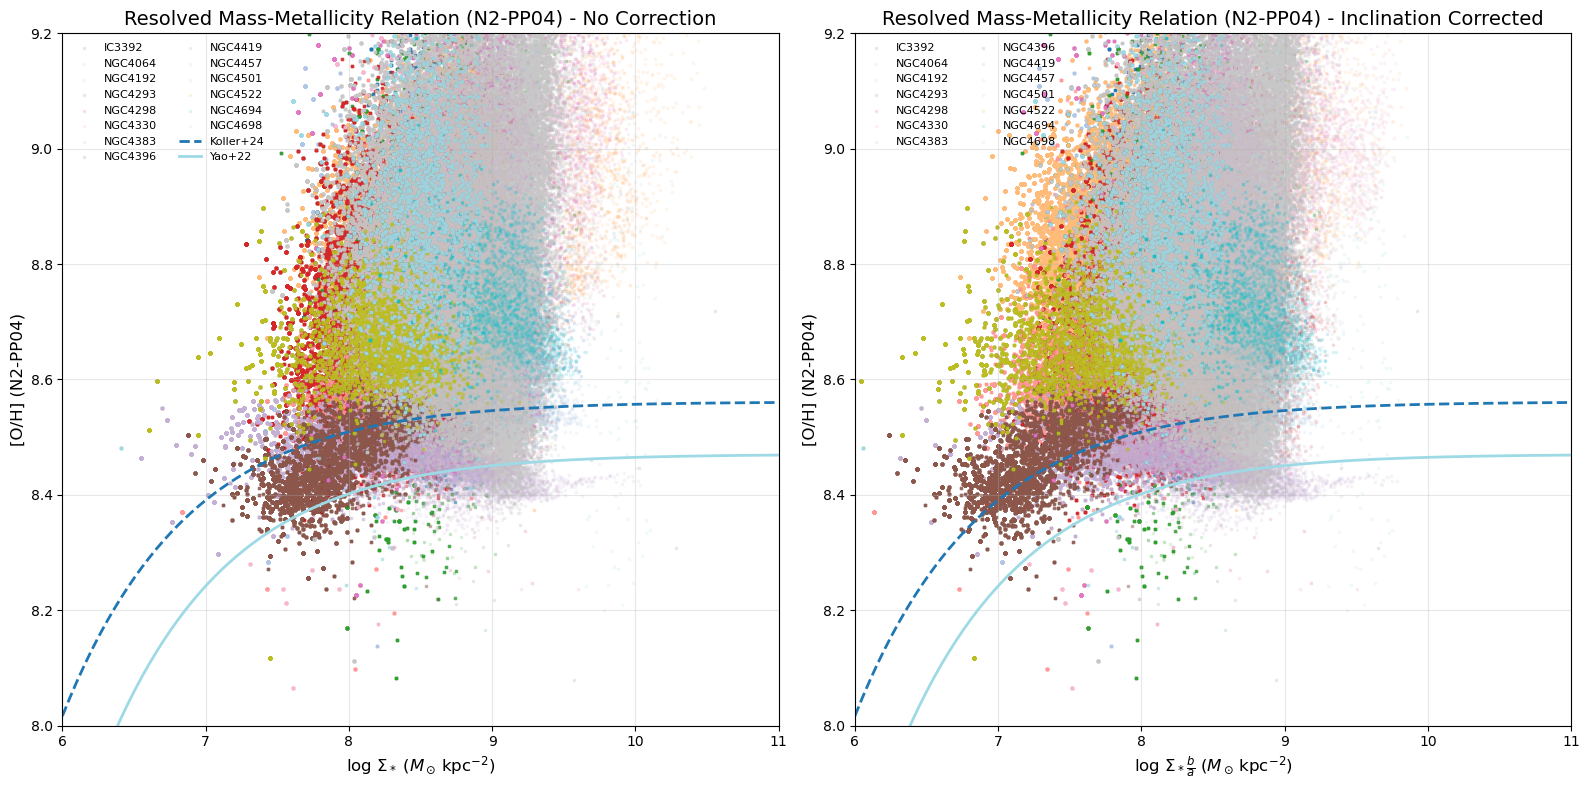

Subplot 1: Plotted uncorrected spatially-resolved N2-PP04 MZR data for 14 galaxies
Subplot 2: Plotted inclination-corrected spatially-resolved N2-PP04 MZR data for 14 galaxies


In [8]:
# ------------------------------------------------------------------
# Combined Plot: Resolved MZR (N2-PP04, No correction) + Resolved MZR (N2-PP04, Inclination-Corrected)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def plot_literature_mzr_fits(ax, show_legend=False):
    """Plot literature MZR fits on the given axis"""
    # Define x range for plotting literature fits
    x = np.linspace(6, 11, 100)
    
    # Yao+22
    # 12 + log(O/H) = a + b(log Σ* - c)e^(-(x-c))
    # Coefficients: a = 8.47, b = 0.0002, c = 12.36
    a1, b1, c1 = 8.47, 0.0002, 12.36
    y_yao22 = a1 + b1 * (x - c1) * np.exp(-(x - c1))

    # Koller+24
    # 12 + log(O/H) = a + b(log Σ* - c)exp(-(log Σ* - c))
    # Coefficients: a = 8.561, b = 0.0001, c = 12.7
    a2, b2, c2 = 8.561, 0.0001, 12.7
    y_koller24 = a2 + b2 * (x - c2) * np.exp(-(x - c2))

    # MZR literature data
    plot_data = [
        (y_koller24, 'Koller+24', '--'),
        (y_yao22, 'Yao+22', '-'),
    ]
    
    # Plot all literature fits
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    for i, (y, label, linestyle) in enumerate(plot_data):
        if show_legend:
            ax.plot(x, y, label=label, linewidth=2, linestyle=linestyle, color=colors[i])
        else:
            ax.plot(x, y, linewidth=2, linestyle=linestyle, color=colors[i])

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Spatially-resolved Σ* vs [O/H] N2-PP04 (No Inclination Correction)
# ------------------------------------------------------------------

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Collect all data points for global fit (subplot 1)
all_x_left = []
all_y_left = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions (NO inclination correction for subplot 1)
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_n2_pp04 = hdul['O_H_N2_PP04_SF'].data  # [O/H] N2-PP04

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_n2_pp04)

        # NO inclination correction applied for subplot 1
        logSigmaM_uncorr = logSigmaM[good]

        # Scatter plot using consistent galaxy colors (no inclination correction)
        ax1.scatter(
            logSigmaM_uncorr,
            oh_n2_pp04[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x_left.extend(logSigmaM_uncorr)
        all_y_left.extend(oh_n2_pp04[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 1
plot_literature_mzr_fits(ax1, show_legend=True)

# Final cosmetics for subplot 1
ax1.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax1.set_ylabel(r'[O/H] (N2-PP04)', fontsize=12)
ax1.set_title(r'Resolved Mass-Metallicity Relation (N2-PP04) - No Correction', fontsize=14)
ax1.set_xlim(6, 11)
ax1.set_ylim(8.0, 9.2)
ax1.grid(True, alpha=0.3)
ax1.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] N2-PP04 (Inclination-Corrected)
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Get galaxy inclination
    galaxy_inclination = read_galaxy_inclination(gal)
    if galaxy_inclination is None:
        print(f"Warning: Skipping {gal} - no inclination data, using uncorrected values")
        inclination_correction = 0.0  # no correction in log space
    else:
        inclination_rad = np.deg2rad(galaxy_inclination)
        cos_inclination = np.cos(inclination_rad)
        # Calculate b/a factor: sqrt((1-q0^2)*cos^2(i) + q0^2) where q0=0.2
        ba_factor = np.abs(np.sqrt((1-0.2**2)*cos_inclination**2 + 0.2**2))
        inclination_correction = np.log10(ba_factor)
        print(f"Galaxy {gal}: inclination = {galaxy_inclination}°, b/a = {ba_factor:.3f}")

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_n2_pp04 = hdul['O_H_N2_PP04_SF'].data  # [O/H] N2-PP04

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_n2_pp04)

        # Apply inclination correction to stellar mass surface density
        logSigmaM_corr = logSigmaM[good] + inclination_correction

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM_corr,
            oh_n2_pp04[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM_corr)
        all_y.extend(oh_n2_pp04[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 2
plot_literature_mzr_fits(ax2, show_legend=False)

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \frac{b}{a} \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (N2-PP04)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (N2-PP04) - Inclination Corrected', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted uncorrected spatially-resolved N2-PP04 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")
print(f"Subplot 2: Plotted inclination-corrected spatially-resolved N2-PP04 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

Galaxy IC3392: inclination = 68.0°, b/a = 0.418
Galaxy NGC4064: inclination = 70.0°, b/a = 0.390
Galaxy NGC4192: inclination = 83.0°, b/a = 0.233
Galaxy NGC4293: inclination = 67.0°, b/a = 0.432
Galaxy NGC4298: inclination = 52.0°, b/a = 0.636
Galaxy NGC4330: inclination = 90.0°, b/a = 0.200
Galaxy NGC4383: inclination = 56.0°, b/a = 0.583
Galaxy NGC4396: inclination = 83.0°, b/a = 0.233
Galaxy NGC4419: inclination = 74.0°, b/a = 0.336
Galaxy NGC4457: inclination = 37.0°, b/a = 0.808
Galaxy NGC4501: inclination = 65.0°, b/a = 0.460
Galaxy NGC4522: inclination = 82.0°, b/a = 0.242
Galaxy NGC4694: inclination = 62.0°, b/a = 0.502
Galaxy NGC4698: inclination = 66.0°, b/a = 0.446


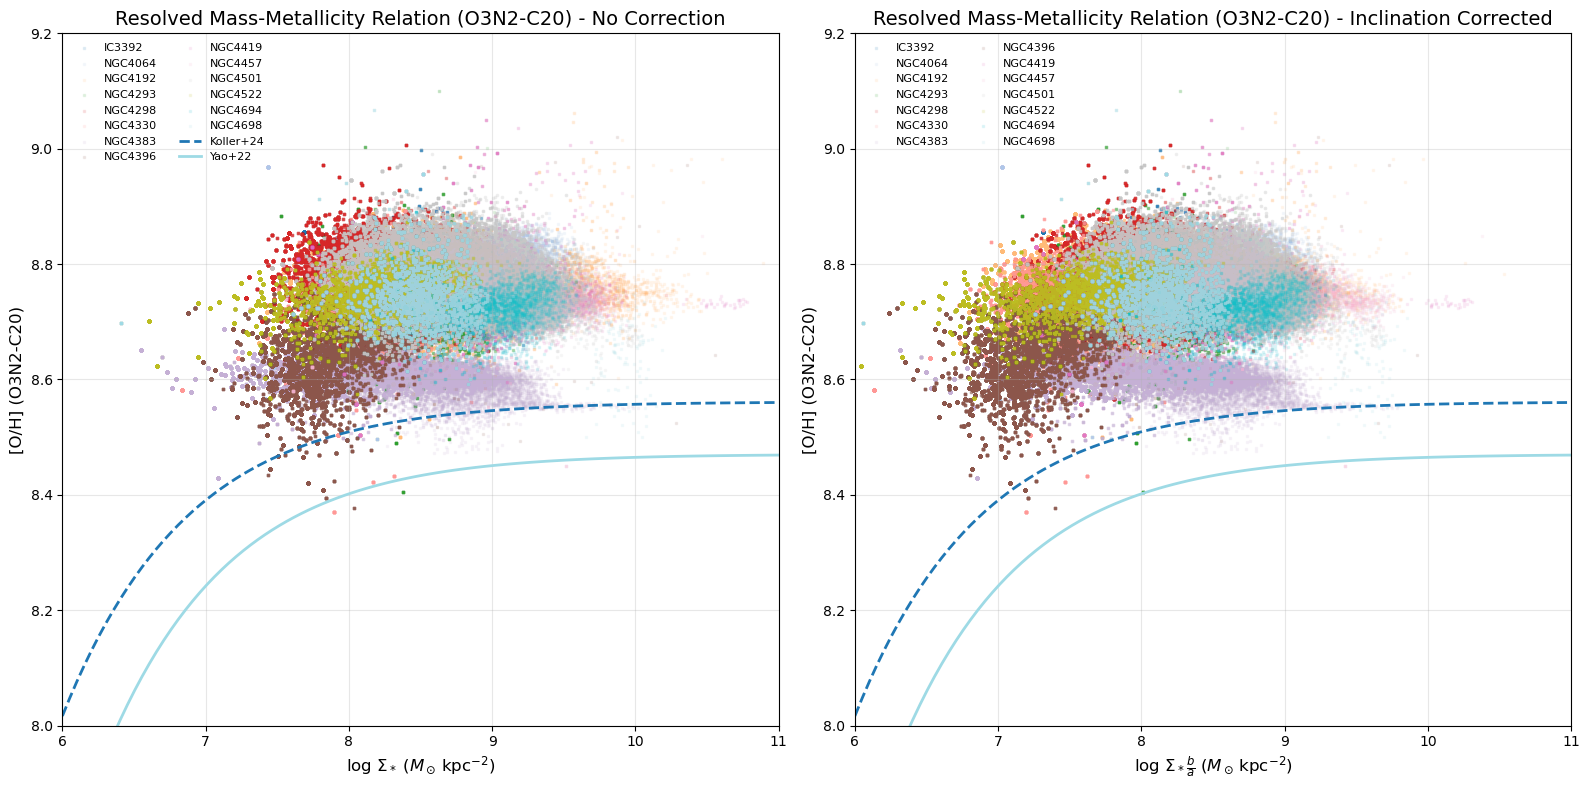

Subplot 1: Plotted uncorrected spatially-resolved O3N2-C20 MZR data for 14 galaxies
Subplot 2: Plotted inclination-corrected spatially-resolved O3N2-C20 MZR data for 14 galaxies


In [9]:
# ------------------------------------------------------------------
# Combined Plot: Resolved MZR (O3N2-C20, No correction) + Resolved MZR (O3N2-C20, Inclination-Corrected)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def plot_literature_mzr_fits(ax, show_legend=False):
    """Plot literature MZR fits on the given axis"""
    # Define x range for plotting literature fits
    x = np.linspace(6, 11, 100)
    
    # Yao+22
    # 12 + log(O/H) = a + b(log Σ* - c)e^(-(x-c))
    # Coefficients: a = 8.47, b = 0.0002, c = 12.36
    a1, b1, c1 = 8.47, 0.0002, 12.36
    y_yao22 = a1 + b1 * (x - c1) * np.exp(-(x - c1))

    # Koller+24
    # 12 + log(O/H) = a + b(log Σ* - c)exp(-(log Σ* - c))
    # Coefficients: a = 8.561, b = 0.0001, c = 12.7
    a2, b2, c2 = 8.561, 0.0001, 12.7
    y_koller24 = a2 + b2 * (x - c2) * np.exp(-(x - c2))

    # MZR literature data
    plot_data = [
        (y_koller24, 'Koller+24', '--'),
        (y_yao22, 'Yao+22', '-'),
    ]
    
    # Plot all literature fits
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    for i, (y, label, linestyle) in enumerate(plot_data):
        if show_legend:
            ax.plot(x, y, label=label, linewidth=2, linestyle=linestyle, color=colors[i])
        else:
            ax.plot(x, y, linewidth=2, linestyle=linestyle, color=colors[i])

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Spatially-resolved Σ* vs [O/H] O3N2-C20 (No Inclination Correction)
# ------------------------------------------------------------------

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Collect all data points for global fit (subplot 1)
all_x_left = []
all_y_left = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions (NO inclination correction for subplot 1)
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_o3n2_c20 = hdul['O_H_O3N2_C20_SF'].data  # [O/H] O3N2-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_o3n2_c20)

        # NO inclination correction applied for subplot 1
        logSigmaM_uncorr = logSigmaM[good]

        # Scatter plot using consistent galaxy colors (no inclination correction)
        ax1.scatter(
            logSigmaM_uncorr,
            oh_o3n2_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x_left.extend(logSigmaM_uncorr)
        all_y_left.extend(oh_o3n2_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 1
plot_literature_mzr_fits(ax1, show_legend=True)

# Final cosmetics for subplot 1
ax1.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax1.set_ylabel(r'[O/H] (O3N2-C20)', fontsize=12)
ax1.set_title(r'Resolved Mass-Metallicity Relation (O3N2-C20) - No Correction', fontsize=14)
ax1.set_xlim(6, 11)
ax1.set_ylim(8.0, 9.2)
ax1.grid(True, alpha=0.3)
ax1.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] O3N2-C20 (Inclination-Corrected)
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Get galaxy inclination
    galaxy_inclination = read_galaxy_inclination(gal)
    if galaxy_inclination is None:
        print(f"Warning: Skipping {gal} - no inclination data, using uncorrected values")
        inclination_correction = 0.0  # no correction in log space
    else:
        inclination_rad = np.deg2rad(galaxy_inclination)
        cos_inclination = np.cos(inclination_rad)
        # Calculate b/a factor: sqrt((1-q0^2)*cos^2(i) + q0^2) where q0=0.2
        ba_factor = np.abs(np.sqrt((1-0.2**2)*cos_inclination**2 + 0.2**2))
        inclination_correction = np.log10(ba_factor)
        print(f"Galaxy {gal}: inclination = {galaxy_inclination}°, b/a = {ba_factor:.3f}")

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_o3n2_c20 = hdul['O_H_O3N2_C20_SF'].data  # [O/H] O3N2-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_o3n2_c20)

        # Apply inclination correction to stellar mass surface density
        logSigmaM_corr = logSigmaM[good] + inclination_correction

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM_corr,
            oh_o3n2_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM_corr)
        all_y.extend(oh_o3n2_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 2
plot_literature_mzr_fits(ax2, show_legend=False)

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \frac{b}{a} \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (O3N2-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (O3N2-C20) - Inclination Corrected', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted uncorrected spatially-resolved O3N2-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")
print(f"Subplot 2: Plotted inclination-corrected spatially-resolved O3N2-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

Galaxy IC3392: inclination = 68.0°, b/a = 0.418
Galaxy NGC4064: inclination = 70.0°, b/a = 0.390
Galaxy NGC4192: inclination = 83.0°, b/a = 0.233
Galaxy NGC4293: inclination = 67.0°, b/a = 0.432
Galaxy NGC4298: inclination = 52.0°, b/a = 0.636
Galaxy NGC4330: inclination = 90.0°, b/a = 0.200
Galaxy NGC4383: inclination = 56.0°, b/a = 0.583
Galaxy NGC4396: inclination = 83.0°, b/a = 0.233
Galaxy NGC4419: inclination = 74.0°, b/a = 0.336
Galaxy NGC4457: inclination = 37.0°, b/a = 0.808
Galaxy NGC4501: inclination = 65.0°, b/a = 0.460
Galaxy NGC4522: inclination = 82.0°, b/a = 0.242
Galaxy NGC4694: inclination = 62.0°, b/a = 0.502
Galaxy NGC4698: inclination = 66.0°, b/a = 0.446


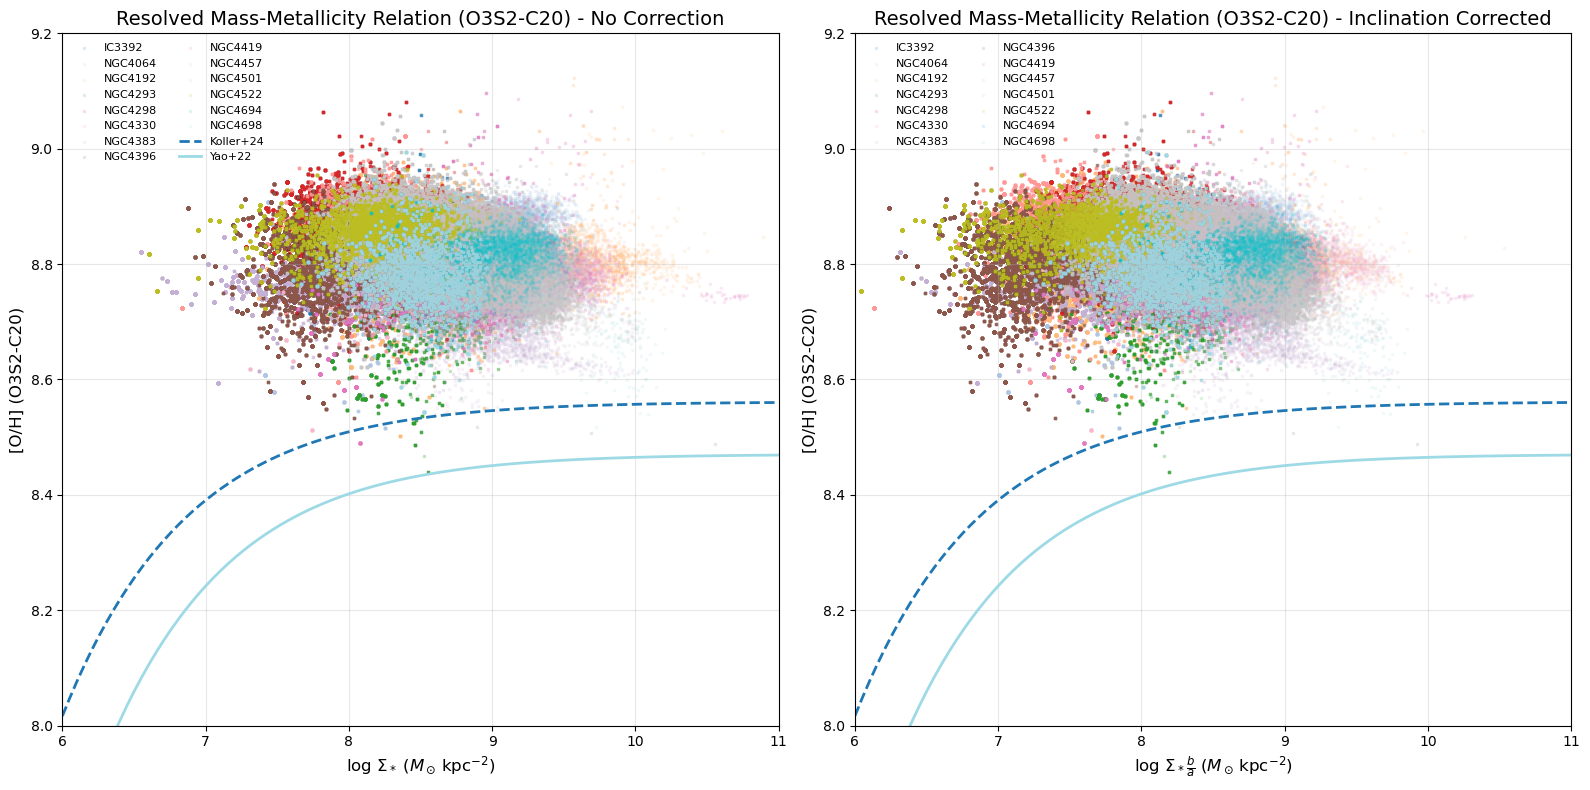

Subplot 1: Plotted uncorrected spatially-resolved O3S2-C20 MZR data for 14 galaxies
Subplot 2: Plotted inclination-corrected spatially-resolved O3S2-C20 MZR data for 14 galaxies


In [10]:
# ------------------------------------------------------------------
# Combined Plot: Resolved MZR (O3S2-C20, No correction) + Resolved MZR (O3S2-C20, Inclination-Corrected)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def plot_literature_mzr_fits(ax, show_legend=False):
    """Plot literature MZR fits on the given axis"""
    # Define x range for plotting literature fits
    x = np.linspace(6, 11, 100)
    
    # Yao+22
    # 12 + log(O/H) = a + b(log Σ* - c)e^(-(x-c))
    # Coefficients: a = 8.47, b = 0.0002, c = 12.36
    a1, b1, c1 = 8.47, 0.0002, 12.36
    y_yao22 = a1 + b1 * (x - c1) * np.exp(-(x - c1))

    # Koller+24
    # 12 + log(O/H) = a + b(log Σ* - c)exp(-(log Σ* - c))
    # Coefficients: a = 8.561, b = 0.0001, c = 12.7
    a2, b2, c2 = 8.561, 0.0001, 12.7
    y_koller24 = a2 + b2 * (x - c2) * np.exp(-(x - c2))

    # MZR literature data
    plot_data = [
        (y_koller24, 'Koller+24', '--'),
        (y_yao22, 'Yao+22', '-'),
    ]
    
    # Plot all literature fits
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    for i, (y, label, linestyle) in enumerate(plot_data):
        if show_legend:
            ax.plot(x, y, label=label, linewidth=2, linestyle=linestyle, color=colors[i])
        else:
            ax.plot(x, y, linewidth=2, linestyle=linestyle, color=colors[i])

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Spatially-resolved Σ* vs [O/H] O3S2-C20 (No Inclination Correction)
# ------------------------------------------------------------------

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Collect all data points for global fit (subplot 1)
all_x_left = []
all_y_left = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions (NO inclination correction for subplot 1)
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_o3s2_c20 = hdul['O_H_O3S2_C20_SF'].data  # [O/H] O3S2-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_o3s2_c20)

        # NO inclination correction applied for subplot 1
        logSigmaM_uncorr = logSigmaM[good]

        # Scatter plot using consistent galaxy colors (no inclination correction)
        ax1.scatter(
            logSigmaM_uncorr,
            oh_o3s2_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x_left.extend(logSigmaM_uncorr)
        all_y_left.extend(oh_o3s2_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 1
plot_literature_mzr_fits(ax1, show_legend=True)

# Final cosmetics for subplot 1
ax1.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax1.set_ylabel(r'[O/H] (O3S2-C20)', fontsize=12)
ax1.set_title(r'Resolved Mass-Metallicity Relation (O3S2-C20) - No Correction', fontsize=14)
ax1.set_xlim(6, 11)
ax1.set_ylim(8.0, 9.2)
ax1.grid(True, alpha=0.3)
ax1.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] O3S2-C20 (Inclination-Corrected)
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Get galaxy inclination
    galaxy_inclination = read_galaxy_inclination(gal)
    if galaxy_inclination is None:
        print(f"Warning: Skipping {gal} - no inclination data, using uncorrected values")
        inclination_correction = 0.0  # no correction in log space
    else:
        inclination_rad = np.deg2rad(galaxy_inclination)
        cos_inclination = np.cos(inclination_rad)
        # Calculate b/a factor: sqrt((1-q0^2)*cos^2(i) + q0^2) where q0=0.2
        ba_factor = np.abs(np.sqrt((1-0.2**2)*cos_inclination**2 + 0.2**2))
        inclination_correction = np.log10(ba_factor)
        print(f"Galaxy {gal}: inclination = {galaxy_inclination}°, b/a = {ba_factor:.3f}")

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_o3s2_c20 = hdul['O_H_O3S2_C20_SF'].data  # [O/H] O3S2-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_o3s2_c20)

        # Apply inclination correction to stellar mass surface density
        logSigmaM_corr = logSigmaM[good] + inclination_correction

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM_corr,
            oh_o3s2_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM_corr)
        all_y.extend(oh_o3s2_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 2
plot_literature_mzr_fits(ax2, show_legend=False)

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \frac{b}{a} \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (O3S2-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (O3S2-C20) - Inclination Corrected', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted uncorrected spatially-resolved O3S2-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")
print(f"Subplot 2: Plotted inclination-corrected spatially-resolved O3S2-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

Galaxy IC3392: inclination = 68.0°, b/a = 0.418
Galaxy NGC4064: inclination = 70.0°, b/a = 0.390
Galaxy NGC4192: inclination = 83.0°, b/a = 0.233
Galaxy NGC4293: inclination = 67.0°, b/a = 0.432
Galaxy NGC4298: inclination = 52.0°, b/a = 0.636
Galaxy NGC4330: inclination = 90.0°, b/a = 0.200
Galaxy NGC4383: inclination = 56.0°, b/a = 0.583
Galaxy NGC4396: inclination = 83.0°, b/a = 0.233
Galaxy NGC4419: inclination = 74.0°, b/a = 0.336
Galaxy NGC4457: inclination = 37.0°, b/a = 0.808
Galaxy NGC4501: inclination = 65.0°, b/a = 0.460
Galaxy NGC4522: inclination = 82.0°, b/a = 0.242
Galaxy NGC4694: inclination = 62.0°, b/a = 0.502
Galaxy NGC4698: inclination = 66.0°, b/a = 0.446


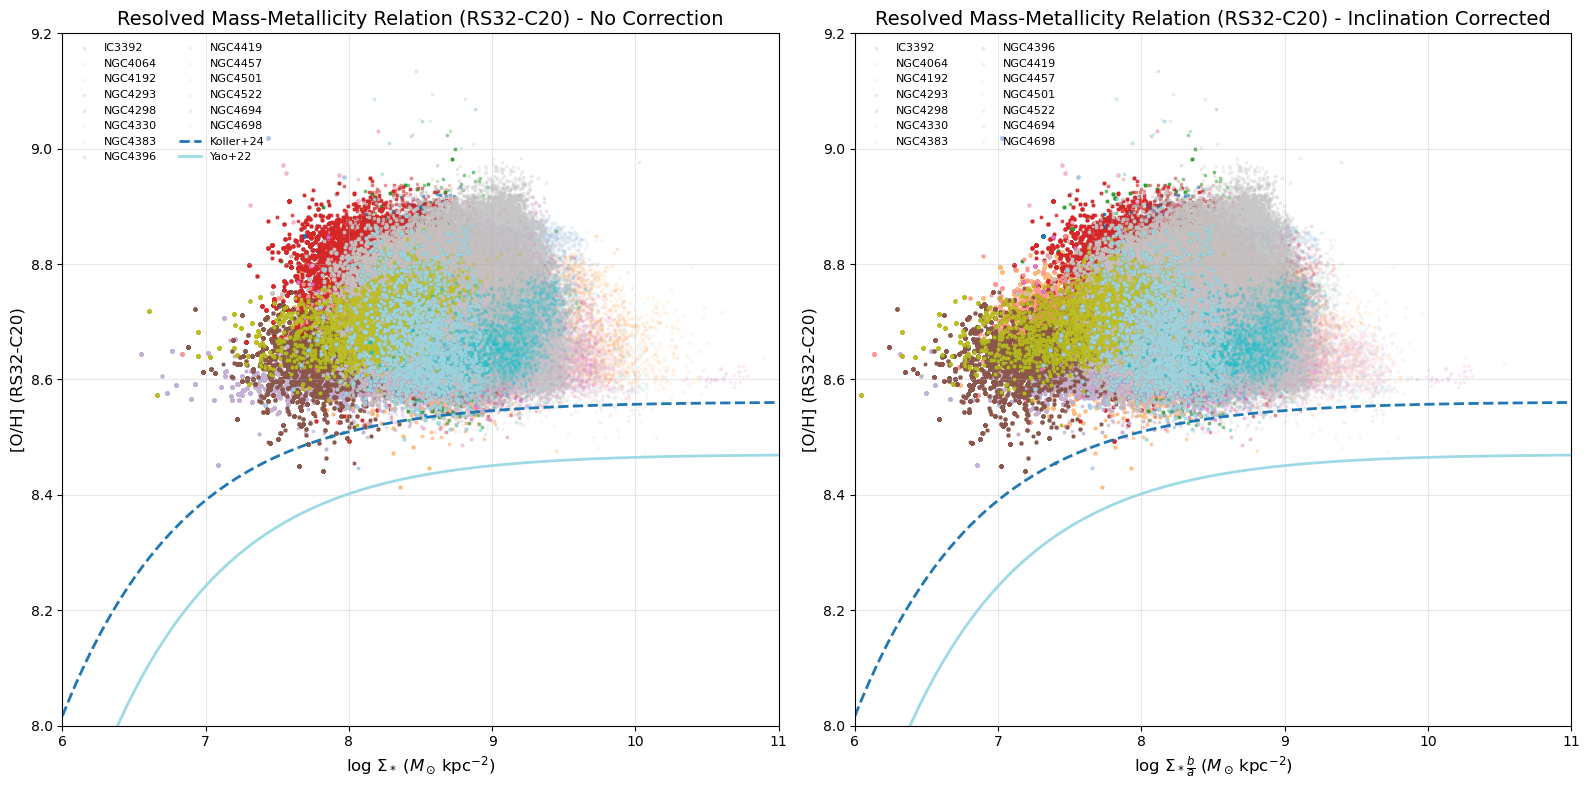

Subplot 1: Plotted uncorrected spatially-resolved RS32-C20 MZR data for 14 galaxies
Subplot 2: Plotted inclination-corrected spatially-resolved RS32-C20 MZR data for 14 galaxies


In [11]:
# ------------------------------------------------------------------
# Combined Plot: Resolved MZR (RS32-C20, No correction) + Resolved MZR (RS32-C20, Inclination-Corrected)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def plot_literature_mzr_fits(ax, show_legend=False):
    """Plot literature MZR fits on the given axis"""
    # Define x range for plotting literature fits
    x = np.linspace(6, 11, 100)
    
    # Yao+22
    # 12 + log(O/H) = a + b(log Σ* - c)e^(-(x-c))
    # Coefficients: a = 8.47, b = 0.0002, c = 12.36
    a1, b1, c1 = 8.47, 0.0002, 12.36
    y_yao22 = a1 + b1 * (x - c1) * np.exp(-(x - c1))

    # Koller+24
    # 12 + log(O/H) = a + b(log Σ* - c)exp(-(log Σ* - c))
    # Coefficients: a = 8.561, b = 0.0001, c = 12.7
    a2, b2, c2 = 8.561, 0.0001, 12.7
    y_koller24 = a2 + b2 * (x - c2) * np.exp(-(x - c2))

    # MZR literature data
    plot_data = [
        (y_koller24, 'Koller+24', '--'),
        (y_yao22, 'Yao+22', '-'),
    ]
    
    # Plot all literature fits
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    for i, (y, label, linestyle) in enumerate(plot_data):
        if show_legend:
            ax.plot(x, y, label=label, linewidth=2, linestyle=linestyle, color=colors[i])
        else:
            ax.plot(x, y, linewidth=2, linestyle=linestyle, color=colors[i])

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Spatially-resolved Σ* vs [O/H] RS32-C20 (No Inclination Correction)
# ------------------------------------------------------------------

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Collect all data points for global fit (subplot 1)
all_x_left = []
all_y_left = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions (NO inclination correction for subplot 1)
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_rs32_c20 = hdul['O_H_RS32_C20_SF'].data  # [O/H] RS32-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_rs32_c20)

        # NO inclination correction applied for subplot 1
        logSigmaM_uncorr = logSigmaM[good]

        # Scatter plot using consistent galaxy colors (no inclination correction)
        ax1.scatter(
            logSigmaM_uncorr,
            oh_rs32_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x_left.extend(logSigmaM_uncorr)
        all_y_left.extend(oh_rs32_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 1
plot_literature_mzr_fits(ax1, show_legend=True)

# Final cosmetics for subplot 1
ax1.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax1.set_ylabel(r'[O/H] (RS32-C20)', fontsize=12)
ax1.set_title(r'Resolved Mass-Metallicity Relation (RS32-C20) - No Correction', fontsize=14)
ax1.set_xlim(6, 11)
ax1.set_ylim(8.0, 9.2)
ax1.grid(True, alpha=0.3)
ax1.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] RS32-C20 (Inclination-Corrected)
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Get galaxy inclination
    galaxy_inclination = read_galaxy_inclination(gal)
    if galaxy_inclination is None:
        print(f"Warning: Skipping {gal} - no inclination data, using uncorrected values")
        inclination_correction = 0.0  # no correction in log space
    else:
        inclination_rad = np.deg2rad(galaxy_inclination)
        cos_inclination = np.cos(inclination_rad)
        # Calculate b/a factor: sqrt((1-q0^2)*cos^2(i) + q0^2) where q0=0.2
        ba_factor = np.abs(np.sqrt((1-0.2**2)*cos_inclination**2 + 0.2**2))
        inclination_correction = np.log10(ba_factor)
        print(f"Galaxy {gal}: inclination = {galaxy_inclination}°, b/a = {ba_factor:.3f}")

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_rs32_c20 = hdul['O_H_RS32_C20_SF'].data  # [O/H] RS32-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_rs32_c20)

        # Apply inclination correction to stellar mass surface density
        logSigmaM_corr = logSigmaM[good] + inclination_correction

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM_corr,
            oh_rs32_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM_corr)
        all_y.extend(oh_rs32_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 2
plot_literature_mzr_fits(ax2, show_legend=False)

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \frac{b}{a} \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (RS32-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (RS32-C20) - Inclination Corrected', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted uncorrected spatially-resolved RS32-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")
print(f"Subplot 2: Plotted inclination-corrected spatially-resolved RS32-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

Galaxy IC3392: inclination = 68.0°, b/a = 0.418
Galaxy NGC4064: inclination = 70.0°, b/a = 0.390
Galaxy NGC4192: inclination = 83.0°, b/a = 0.233
Galaxy NGC4293: inclination = 67.0°, b/a = 0.432
Galaxy NGC4298: inclination = 52.0°, b/a = 0.636
Galaxy NGC4330: inclination = 90.0°, b/a = 0.200
Galaxy NGC4383: inclination = 56.0°, b/a = 0.583
Galaxy NGC4396: inclination = 83.0°, b/a = 0.233
Galaxy NGC4419: inclination = 74.0°, b/a = 0.336
Galaxy NGC4457: inclination = 37.0°, b/a = 0.808
Galaxy NGC4501: inclination = 65.0°, b/a = 0.460
Galaxy NGC4522: inclination = 82.0°, b/a = 0.242
Galaxy NGC4694: inclination = 62.0°, b/a = 0.502
Galaxy NGC4698: inclination = 66.0°, b/a = 0.446


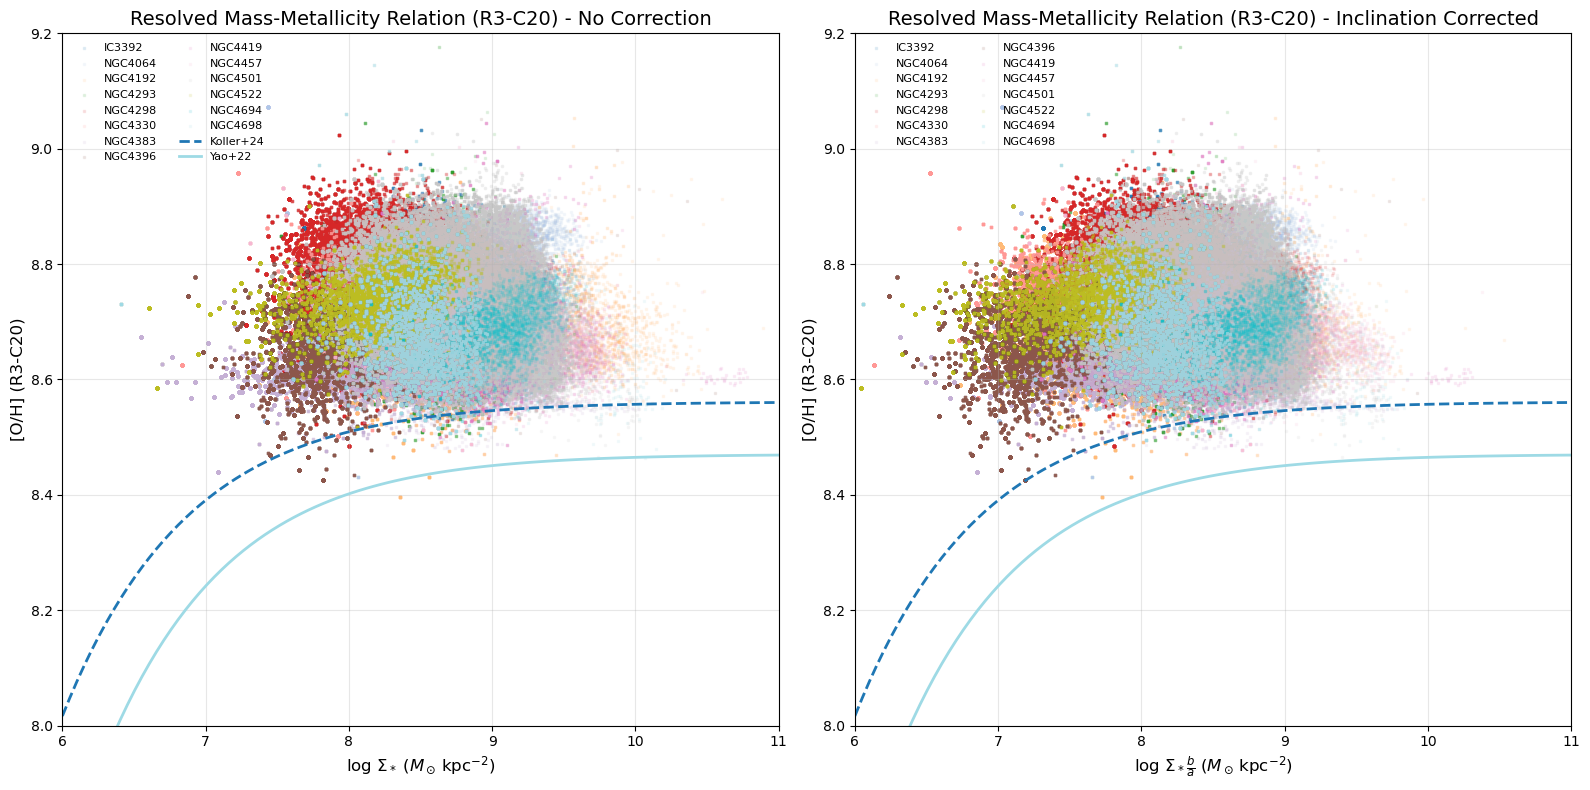

Subplot 1: Plotted uncorrected spatially-resolved R3-C20 MZR data for 14 galaxies
Subplot 2: Plotted inclination-corrected spatially-resolved R3-C20 MZR data for 14 galaxies


In [12]:
# ------------------------------------------------------------------
# Combined Plot: Resolved MZR (R3-C20, No correction) + Resolved MZR (R3-C20, Inclination-Corrected)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def plot_literature_mzr_fits(ax, show_legend=False):
    """Plot literature MZR fits on the given axis"""
    # Define x range for plotting literature fits
    x = np.linspace(6, 11, 100)
    
    # Yao+22
    # 12 + log(O/H) = a + b(log Σ* - c)e^(-(x-c))
    # Coefficients: a = 8.47, b = 0.0002, c = 12.36
    a1, b1, c1 = 8.47, 0.0002, 12.36
    y_yao22 = a1 + b1 * (x - c1) * np.exp(-(x - c1))

    # Koller+24
    # 12 + log(O/H) = a + b(log Σ* - c)exp(-(log Σ* - c))
    # Coefficients: a = 8.561, b = 0.0001, c = 12.7
    a2, b2, c2 = 8.561, 0.0001, 12.7
    y_koller24 = a2 + b2 * (x - c2) * np.exp(-(x - c2))

    # MZR literature data
    plot_data = [
        (y_koller24, 'Koller+24', '--'),
        (y_yao22, 'Yao+22', '-'),
    ]
    
    # Plot all literature fits
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    for i, (y, label, linestyle) in enumerate(plot_data):
        if show_legend:
            ax.plot(x, y, label=label, linewidth=2, linestyle=linestyle, color=colors[i])
        else:
            ax.plot(x, y, linewidth=2, linestyle=linestyle, color=colors[i])

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Spatially-resolved Σ* vs [O/H] R3-C20 (No Inclination Correction)
# ------------------------------------------------------------------

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Collect all data points for global fit (subplot 1)
all_x_left = []
all_y_left = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions (NO inclination correction for subplot 1)
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_r3_c20 = hdul['O_H_R3_C20_SF'].data  # [O/H] R3-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_r3_c20)

        # NO inclination correction applied for subplot 1
        logSigmaM_uncorr = logSigmaM[good]

        # Scatter plot using consistent galaxy colors (no inclination correction)
        ax1.scatter(
            logSigmaM_uncorr,
            oh_r3_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x_left.extend(logSigmaM_uncorr)
        all_y_left.extend(oh_r3_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 1
plot_literature_mzr_fits(ax1, show_legend=True)

# Final cosmetics for subplot 1
ax1.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax1.set_ylabel(r'[O/H] (R3-C20)', fontsize=12)
ax1.set_title(r'Resolved Mass-Metallicity Relation (R3-C20) - No Correction', fontsize=14)
ax1.set_xlim(6, 11)
ax1.set_ylim(8.0, 9.2)
ax1.grid(True, alpha=0.3)
ax1.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] R3-C20 (Inclination-Corrected)
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Get galaxy inclination
    galaxy_inclination = read_galaxy_inclination(gal)
    if galaxy_inclination is None:
        print(f"Warning: Skipping {gal} - no inclination data, using uncorrected values")
        inclination_correction = 0.0  # no correction in log space
    else:
        inclination_rad = np.deg2rad(galaxy_inclination)
        cos_inclination = np.cos(inclination_rad)
        # Calculate b/a factor: sqrt((1-q0^2)*cos^2(i) + q0^2) where q0=0.2
        ba_factor = np.abs(np.sqrt((1-0.2**2)*cos_inclination**2 + 0.2**2))
        inclination_correction = np.log10(ba_factor)
        print(f"Galaxy {gal}: inclination = {galaxy_inclination}°, b/a = {ba_factor:.3f}")

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_r3_c20 = hdul['O_H_R3_C20_SF'].data  # [O/H] R3-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_r3_c20)

        # Apply inclination correction to stellar mass surface density
        logSigmaM_corr = logSigmaM[good] + inclination_correction

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM_corr,
            oh_r3_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM_corr)
        all_y.extend(oh_r3_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 2
plot_literature_mzr_fits(ax2, show_legend=False)

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \frac{b}{a} \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (R3-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (R3-C20) - Inclination Corrected', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted uncorrected spatially-resolved R3-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")
print(f"Subplot 2: Plotted inclination-corrected spatially-resolved R3-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

Galaxy IC3392: inclination = 68.0°, b/a = 0.418
Galaxy NGC4064: inclination = 70.0°, b/a = 0.390
Galaxy NGC4192: inclination = 83.0°, b/a = 0.233
Galaxy NGC4293: inclination = 67.0°, b/a = 0.432
Galaxy NGC4298: inclination = 52.0°, b/a = 0.636
Galaxy NGC4330: inclination = 90.0°, b/a = 0.200
Galaxy NGC4383: inclination = 56.0°, b/a = 0.583
Galaxy NGC4396: inclination = 83.0°, b/a = 0.233
Galaxy NGC4419: inclination = 74.0°, b/a = 0.336
Galaxy NGC4457: inclination = 37.0°, b/a = 0.808
Galaxy NGC4501: inclination = 65.0°, b/a = 0.460
Galaxy NGC4522: inclination = 82.0°, b/a = 0.242
Galaxy NGC4694: inclination = 62.0°, b/a = 0.502
Galaxy NGC4698: inclination = 66.0°, b/a = 0.446


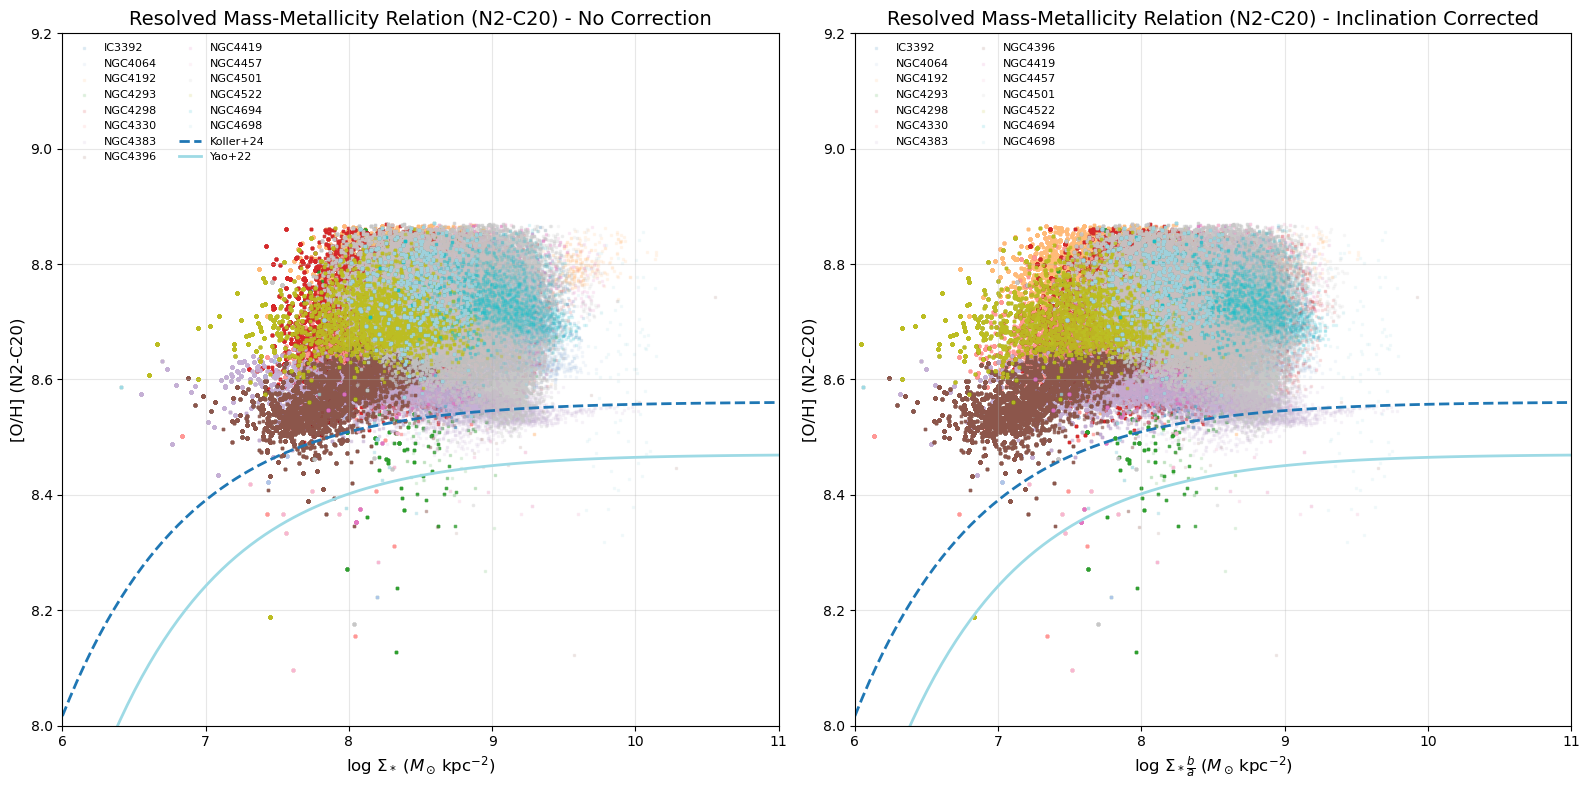

Subplot 1: Plotted uncorrected spatially-resolved N2-C20 MZR data for 14 galaxies
Subplot 2: Plotted inclination-corrected spatially-resolved N2-C20 MZR data for 14 galaxies


In [13]:
# ------------------------------------------------------------------
# Combined Plot: Resolved MZR (N2-C20, No correction) + Resolved MZR (N2-C20, Inclination-Corrected)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def plot_literature_mzr_fits(ax, show_legend=False):
    """Plot literature MZR fits on the given axis"""
    # Define x range for plotting literature fits
    x = np.linspace(6, 11, 100)
    
    # Yao+22
    # 12 + log(O/H) = a + b(log Σ* - c)e^(-(x-c))
    # Coefficients: a = 8.47, b = 0.0002, c = 12.36
    a1, b1, c1 = 8.47, 0.0002, 12.36
    y_yao22 = a1 + b1 * (x - c1) * np.exp(-(x - c1))

    # Koller+24
    # 12 + log(O/H) = a + b(log Σ* - c)exp(-(log Σ* - c))
    # Coefficients: a = 8.561, b = 0.0001, c = 12.7
    a2, b2, c2 = 8.561, 0.0001, 12.7
    y_koller24 = a2 + b2 * (x - c2) * np.exp(-(x - c2))

    # MZR literature data
    plot_data = [
        (y_koller24, 'Koller+24', '--'),
        (y_yao22, 'Yao+22', '-'),
    ]
    
    # Plot all literature fits
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    for i, (y, label, linestyle) in enumerate(plot_data):
        if show_legend:
            ax.plot(x, y, label=label, linewidth=2, linestyle=linestyle, color=colors[i])
        else:
            ax.plot(x, y, linewidth=2, linestyle=linestyle, color=colors[i])

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Spatially-resolved Σ* vs [O/H] N2-C20 (No Inclination Correction)
# ------------------------------------------------------------------

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Collect all data points for global fit (subplot 1)
all_x_left = []
all_y_left = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions (NO inclination correction for subplot 1)
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_n2_c20 = hdul['O_H_N2_C20_SF'].data  # [O/H] N2-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_n2_c20)

        # NO inclination correction applied for subplot 1
        logSigmaM_uncorr = logSigmaM[good]

        # Scatter plot using consistent galaxy colors (no inclination correction)
        ax1.scatter(
            logSigmaM_uncorr,
            oh_n2_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x_left.extend(logSigmaM_uncorr)
        all_y_left.extend(oh_n2_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 1
plot_literature_mzr_fits(ax1, show_legend=True)

# Final cosmetics for subplot 1
ax1.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax1.set_ylabel(r'[O/H] (N2-C20)', fontsize=12)
ax1.set_title(r'Resolved Mass-Metallicity Relation (N2-C20) - No Correction', fontsize=14)
ax1.set_xlim(6, 11)
ax1.set_ylim(8.0, 9.2)
ax1.grid(True, alpha=0.3)
ax1.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] N2-C20 (Inclination-Corrected)
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Get galaxy inclination
    galaxy_inclination = read_galaxy_inclination(gal)
    if galaxy_inclination is None:
        print(f"Warning: Skipping {gal} - no inclination data, using uncorrected values")
        inclination_correction = 0.0  # no correction in log space
    else:
        inclination_rad = np.deg2rad(galaxy_inclination)
        cos_inclination = np.cos(inclination_rad)
        # Calculate b/a factor: sqrt((1-q0^2)*cos^2(i) + q0^2) where q0=0.2
        ba_factor = np.abs(np.sqrt((1-0.2**2)*cos_inclination**2 + 0.2**2))
        inclination_correction = np.log10(ba_factor)
        print(f"Galaxy {gal}: inclination = {galaxy_inclination}°, b/a = {ba_factor:.3f}")

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_n2_c20 = hdul['O_H_N2_C20_SF'].data  # [O/H] N2-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_n2_c20)

        # Apply inclination correction to stellar mass surface density
        logSigmaM_corr = logSigmaM[good] + inclination_correction

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM_corr,
            oh_n2_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM_corr)
        all_y.extend(oh_n2_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 2
plot_literature_mzr_fits(ax2, show_legend=False)

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \frac{b}{a} \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (N2-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (N2-C20) - Inclination Corrected', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted uncorrected spatially-resolved N2-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")
print(f"Subplot 2: Plotted inclination-corrected spatially-resolved N2-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

Galaxy IC3392: inclination = 68.0°, b/a = 0.418
Galaxy NGC4064: inclination = 70.0°, b/a = 0.390
Galaxy NGC4192: inclination = 83.0°, b/a = 0.233
Galaxy NGC4293: inclination = 67.0°, b/a = 0.432
Galaxy NGC4298: inclination = 52.0°, b/a = 0.636
Galaxy NGC4330: inclination = 90.0°, b/a = 0.200
Galaxy NGC4383: inclination = 56.0°, b/a = 0.583
Galaxy NGC4396: inclination = 83.0°, b/a = 0.233
Galaxy NGC4419: inclination = 74.0°, b/a = 0.336
Galaxy NGC4457: inclination = 37.0°, b/a = 0.808
Galaxy NGC4501: inclination = 65.0°, b/a = 0.460
Galaxy NGC4522: inclination = 82.0°, b/a = 0.242
Galaxy NGC4694: inclination = 62.0°, b/a = 0.502
Galaxy NGC4698: inclination = 66.0°, b/a = 0.446


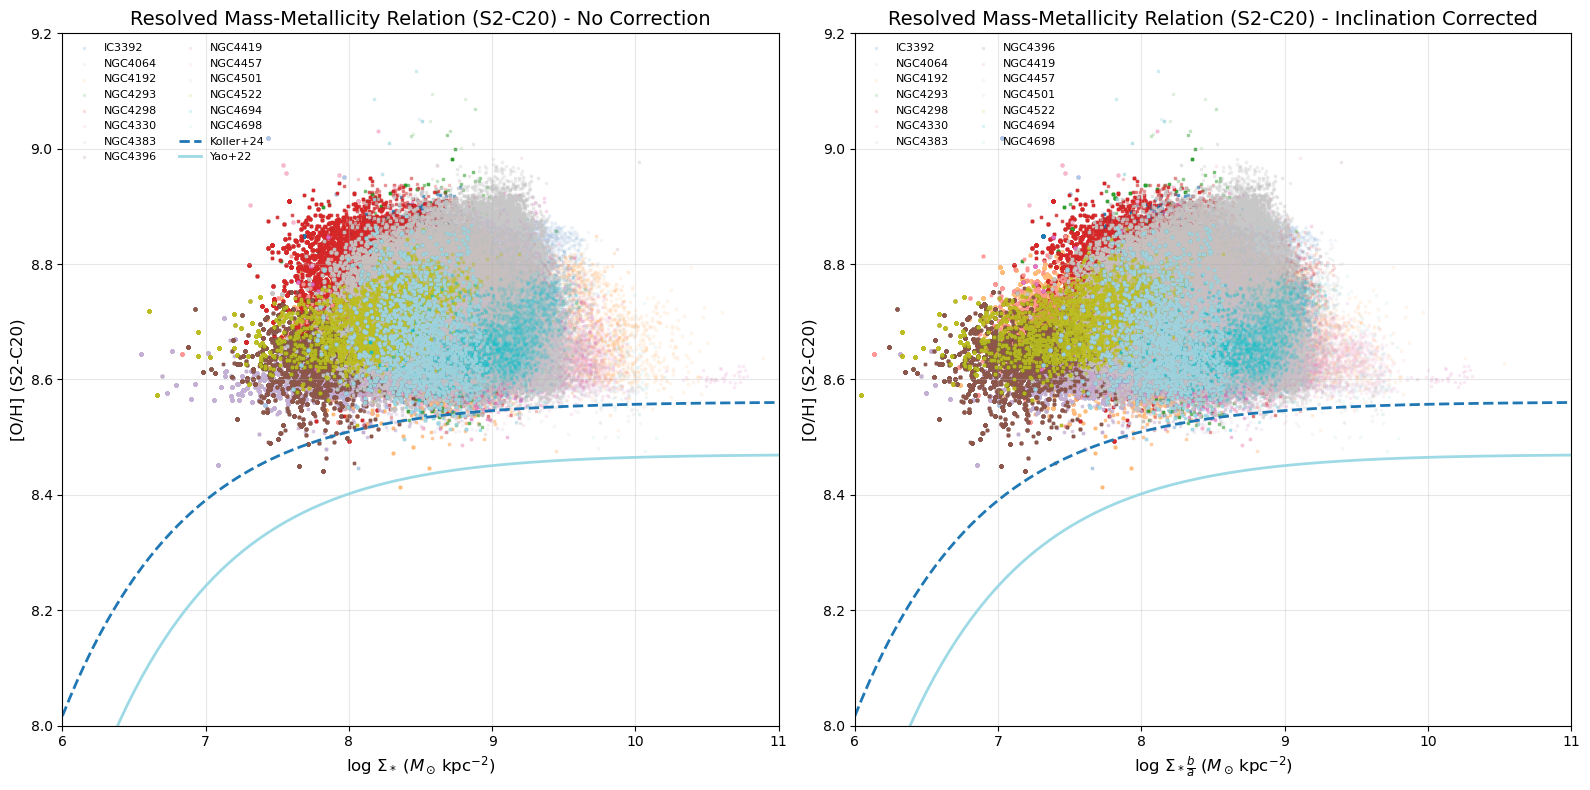

Subplot 1: Plotted uncorrected spatially-resolved S2-C20 MZR data for 14 galaxies
Subplot 2: Plotted inclination-corrected spatially-resolved S2-C20 MZR data for 14 galaxies


In [14]:
# ------------------------------------------------------------------
#
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def plot_literature_mzr_fits(ax, show_legend=False):
    """Plot literature MZR fits on the given axis"""
    # Define x range for plotting literature fits
    x = np.linspace(6, 11, 100)
    
    # Yao+22
    # 12 + log(O/H) = a + b(log Σ* - c)e^(-(x-c))
    # Coefficients: a = 8.47, b = 0.0002, c = 12.36
    a1, b1, c1 = 8.47, 0.0002, 12.36
    y_yao22 = a1 + b1 * (x - c1) * np.exp(-(x - c1))

    # Koller+24
    # 12 + log(O/H) = a + b(log Σ* - c)exp(-(log Σ* - c))
    # Coefficients: a = 8.561, b = 0.0001, c = 12.7
    a2, b2, c2 = 8.561, 0.0001, 12.7
    y_koller24 = a2 + b2 * (x - c2) * np.exp(-(x - c2))

    # MZR literature data
    plot_data = [
        (y_koller24, 'Koller+24', '--'),
        (y_yao22, 'Yao+22', '-'),
    ]
    
    # Plot all literature fits
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    for i, (y, label, linestyle) in enumerate(plot_data):
        if show_legend:
            ax.plot(x, y, label=label, linewidth=2, linestyle=linestyle, color=colors[i])
        else:
            ax.plot(x, y, linewidth=2, linestyle=linestyle, color=colors[i])

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Spatially-resolved Σ* vs [O/H] S2-C20 (No Inclination Correction)
# ------------------------------------------------------------------

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Collect all data points for global fit (subplot 1)
all_x_left = []
all_y_left = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions (NO inclination correction for subplot 1)
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_s2_c20 = hdul['O_H_RS32_C20_SF'].data  # [O/H] S2-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_s2_c20)

        # NO inclination correction applied for subplot 1
        logSigmaM_uncorr = logSigmaM[good]

        # Scatter plot using consistent galaxy colors (no inclination correction)
        ax1.scatter(
            logSigmaM_uncorr,
            oh_s2_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x_left.extend(logSigmaM_uncorr)
        all_y_left.extend(oh_s2_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 1
plot_literature_mzr_fits(ax1, show_legend=True)

# Final cosmetics for subplot 1
ax1.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax1.set_ylabel(r'[O/H] (S2-C20)', fontsize=12)
ax1.set_title(r'Resolved Mass-Metallicity Relation (S2-C20) - No Correction', fontsize=14)
ax1.set_xlim(6, 11)
ax1.set_ylim(8.0, 9.2)
ax1.grid(True, alpha=0.3)
ax1.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] S2-C20 (Inclination-Corrected)
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Get galaxy inclination
    galaxy_inclination = read_galaxy_inclination(gal)
    if galaxy_inclination is None:
        print(f"Warning: Skipping {gal} - no inclination data, using uncorrected values")
        inclination_correction = 0.0  # no correction in log space
    else:
        inclination_rad = np.deg2rad(galaxy_inclination)
        cos_inclination = np.cos(inclination_rad)
        # Calculate b/a factor: sqrt((1-q0^2)*cos^2(i) + q0^2) where q0=0.2
        ba_factor = np.abs(np.sqrt((1-0.2**2)*cos_inclination**2 + 0.2**2))
        inclination_correction = np.log10(ba_factor)
        print(f"Galaxy {gal}: inclination = {galaxy_inclination}°, b/a = {ba_factor:.3f}")

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_s2_c20 = hdul['O_H_RS32_C20_SF'].data  # [O/H] S2-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_s2_c20)

        # Apply inclination correction to stellar mass surface density
        logSigmaM_corr = logSigmaM[good] + inclination_correction

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM_corr,
            oh_s2_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM_corr)
        all_y.extend(oh_s2_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 2
plot_literature_mzr_fits(ax2, show_legend=False)

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \frac{b}{a} \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (S2-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (S2-C20) - Inclination Corrected', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted uncorrected spatially-resolved S2-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")
print(f"Subplot 2: Plotted inclination-corrected spatially-resolved S2-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

Galaxy IC3392: inclination = 68.0°, b/a = 0.418
Galaxy NGC4064: inclination = 70.0°, b/a = 0.390
Galaxy NGC4192: inclination = 83.0°, b/a = 0.233
Galaxy NGC4293: inclination = 67.0°, b/a = 0.432
Galaxy NGC4298: inclination = 52.0°, b/a = 0.636
Galaxy NGC4330: inclination = 90.0°, b/a = 0.200
Galaxy NGC4383: inclination = 56.0°, b/a = 0.583
Galaxy NGC4396: inclination = 83.0°, b/a = 0.233
Galaxy NGC4419: inclination = 74.0°, b/a = 0.336
Galaxy NGC4457: inclination = 37.0°, b/a = 0.808
Galaxy NGC4501: inclination = 65.0°, b/a = 0.460
Galaxy NGC4522: inclination = 82.0°, b/a = 0.242
Galaxy NGC4694: inclination = 62.0°, b/a = 0.502
Galaxy NGC4698: inclination = 66.0°, b/a = 0.446


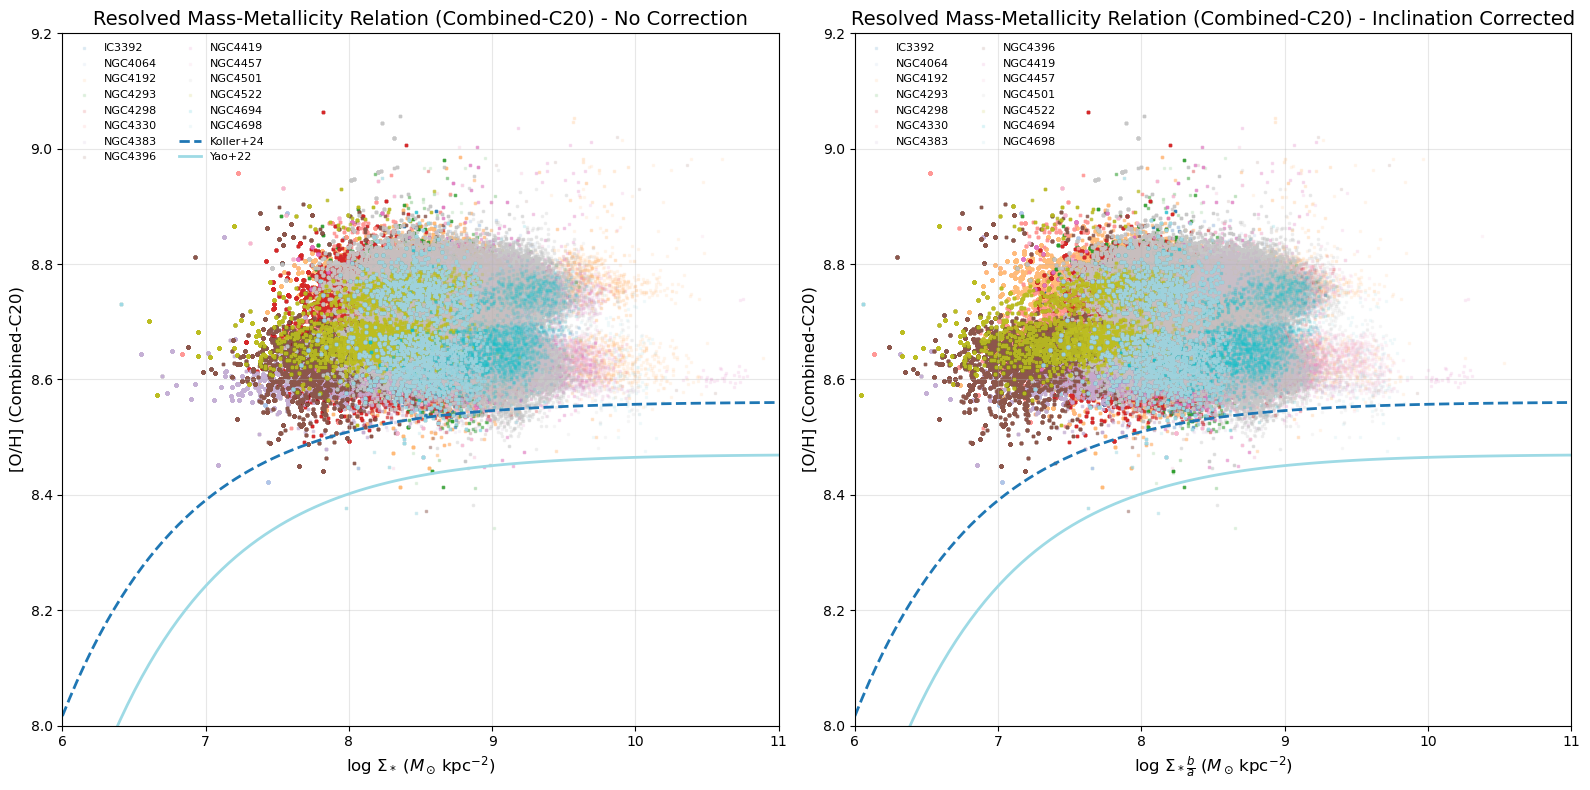

Subplot 1: Plotted uncorrected spatially-resolved Combined-C20 MZR data for 14 galaxies
Subplot 2: Plotted inclination-corrected spatially-resolved Combined-C20 MZR data for 14 galaxies


In [15]:
# ------------------------------------------------------------------
# Combined Plot: Resolved MZR (Combined-C20, No correction) + Resolved MZR (Combined-C20, Inclination-Corrected)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def plot_literature_mzr_fits(ax, show_legend=False):
    """Plot literature MZR fits on the given axis"""
    # Define x range for plotting literature fits
    x = np.linspace(6, 11, 100)
    
    # Yao+22
    # 12 + log(O/H) = a + b(log Σ* - c)e^(-(x-c))
    # Coefficients: a = 8.47, b = 0.0002, c = 12.36
    a1, b1, c1 = 8.47, 0.0002, 12.36
    y_yao22 = a1 + b1 * (x - c1) * np.exp(-(x - c1))

    # Koller+24
    # 12 + log(O/H) = a + b(log Σ* - c)exp(-(log Σ* - c))
    # Coefficients: a = 8.561, b = 0.0001, c = 12.7
    a2, b2, c2 = 8.561, 0.0001, 12.7
    y_koller24 = a2 + b2 * (x - c2) * np.exp(-(x - c2))

    # MZR literature data
    plot_data = [
        (y_koller24, 'Koller+24', '--'),
        (y_yao22, 'Yao+22', '-'),
    ]
    
    # Plot all literature fits
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    for i, (y, label, linestyle) in enumerate(plot_data):
        if show_legend:
            ax.plot(x, y, label=label, linewidth=2, linestyle=linestyle, color=colors[i])
        else:
            ax.plot(x, y, linewidth=2, linestyle=linestyle, color=colors[i])

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Spatially-resolved Σ* vs [O/H] Combined-C20 (No Inclination Correction)
# ------------------------------------------------------------------

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Collect all data points for global fit (subplot 1)
all_x_left = []
all_y_left = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions (NO inclination correction for subplot 1)
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_combined_c20 = hdul['O_H_COMBINED_C20_SF'].data  # [O/H] Combined-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_combined_c20)

        # NO inclination correction applied for subplot 1
        logSigmaM_uncorr = logSigmaM[good]

        # Scatter plot using consistent galaxy colors (no inclination correction)
        ax1.scatter(
            logSigmaM_uncorr,
            oh_combined_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x_left.extend(logSigmaM_uncorr)
        all_y_left.extend(oh_combined_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 1
plot_literature_mzr_fits(ax1, show_legend=True)

# Final cosmetics for subplot 1
ax1.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax1.set_ylabel(r'[O/H] (Combined-C20)', fontsize=12)
ax1.set_title(r'Resolved Mass-Metallicity Relation (Combined-C20) - No Correction', fontsize=14)
ax1.set_xlim(6, 11)
ax1.set_ylim(8.0, 9.2)
ax1.grid(True, alpha=0.3)
ax1.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] Combined-C20 (Inclination-Corrected)
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Get galaxy inclination
    galaxy_inclination = read_galaxy_inclination(gal)
    if galaxy_inclination is None:
        print(f"Warning: Skipping {gal} - no inclination data, using uncorrected values")
        inclination_correction = 0.0  # no correction in log space
    else:
        inclination_rad = np.deg2rad(galaxy_inclination)
        cos_inclination = np.cos(inclination_rad)
        # Calculate b/a factor: sqrt((1-q0^2)*cos^2(i) + q0^2) where q0=0.2
        ba_factor = np.abs(np.sqrt((1-0.2**2)*cos_inclination**2 + 0.2**2))
        inclination_correction = np.log10(ba_factor)
        print(f"Galaxy {gal}: inclination = {galaxy_inclination}°, b/a = {ba_factor:.3f}")

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_combined_c20 = hdul['O_H_COMBINED_C20_SF'].data  # [O/H] Combined-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_combined_c20)

        # Apply inclination correction to stellar mass surface density
        logSigmaM_corr = logSigmaM[good] + inclination_correction

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM_corr,
            oh_combined_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM_corr)
        all_y.extend(oh_combined_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Add literature fitting curves to subplot 2
plot_literature_mzr_fits(ax2, show_legend=False)

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \frac{b}{a} \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (Combined-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (Combined-C20) - Inclination Corrected', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted uncorrected spatially-resolved Combined-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")
print(f"Subplot 2: Plotted inclination-corrected spatially-resolved Combined-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")